<h2 align='center'> <b> Creating AutoML with Azure Python SDK </b></h2>

Reference : 
1. https://github.com/binodsuman/azure_ml (OG Content)
2. https://learn.microsoft.com/en-us/training/modules/intro-to-azure-machine-learning-service/4-azure-ml-experiment
3. https://www.youtube.com/watch?v=Lxdui2F2Zw8&ab_channel=AmbarishGanguly (Datastore)
4. https://github.com/anikch/azure-ml
5. MLOPS : https://www.sqlservergeeks.com/azure-machine-learning-for-mlops-by-mercy-ranjith/"

**STEP 1:** Go to azure and create an account from https://portal.azure.com/#home <br>
**STEP 2 :** Go to Anaconda and create an environment to work with azure ML specifically.

Follow the steps to create a virtual env in Azure:<br>
- Create an environment : conda create --name azure_ml_env
- Activate the virtual env : conda activate azure_ml_env

**STEP 3:** Install python azure-ml sdk : pip install azureml-sdk<br>
This step takes time and if some of the installation fails, do upgrade pip version by the command : python -m pip install --upgrade pip

In [1]:
pip show azureml-sdk  ### To show azureml-sdk version

Name: azureml-sdk
Version: 1.49.0
Summary: Used to build and run machine learning workflows upon the     Azure Machine Learning service.
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: 
License: https://aka.ms/azureml-sdk-license
Location: c:\users\krish\anaconda3\envs\azure_ml_env\lib\site-packages
Requires: azureml-core, azureml-dataset-runtime, azureml-pipeline, azureml-train-automl-client, azureml-train-core
Required-by: 
---
Name: azureml-sdk
Version: 1.49.0
Summary: Used to build and run machine learning workflows upon the     Azure Machine Learning service.
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: 
License: https://aka.ms/azureml-sdk-license
Location: c:\users\krish\anaconda3\envs\azure_ml_env\lib\site-packages
Requires: azureml-core, azureml-dataset-runtime, azureml-pipeline, azureml-train-automl-client, azureml-train-core
Re

**STEP 4:** Install Jupyter by using : pip install jupyter<br>
**STEP 5:** Launch jupyter notebook by using command: jupyter notebook 

**STEP 6:** Go to azure -> Subscription and check the subscription id you have.

**STEP 7:** Importing the necessary libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import azureml
import azure.core
from azureml.core import Workspace,Environment,Experiment,ScriptRunConfig
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core import Model

**STEP 8:** Specifying the suitable configuration info

In [4]:
resource_name = "KD_resource_group"
workspace_name = "KD_demo_workspace"
subscriptionID = "da7f92e5-f637-4517-90fb-493d47170db2" # Please enter your subscription id here
aml_compute_target = "KD-cluster"                       # ALL SMALL LETTER, NO underscore, 16ws long only.
experiment_name= 'demo_expirement_1'
environment_name = 'azure_ml_demo'

**STEP 9:** Creating a new workspace if not created

In [5]:
# Now create Workspace if no workspace is there
try:
    ws=Workspace.from_config()
    print('Workspace is already exist')
except:
    ws=Workspace.create(workspace_name, 
                    resource_group=resource_name,
                    create_resource_group=False,      # If this is made true a new resource-group will be created
                    subscription_id=subscriptionID,
                    location="Central India")
    ws.write_config('.azureml')

Performing interactive authentication. Please follow the instructions on the terminal.


The default web browser has been opened at https://login.microsoftonline.com/organizations/oauth2/v2.0/authorize. Please continue the login in the web browser. If no web browser is available or if the web browser fails to open, use device code flow with `az login --use-device-code`.


Interactive authentication successfully completed.
Deploying StorageAccount with name kddemowostorage3c2969387.
Deploying AppInsights with name kddemowoinsights50a9da65.
Deployed AppInsights with name kddemowoinsights50a9da65. Took 8.69 seconds.
Deploying Workspace with name KD_demo_workspace.
Deployed Workspace with name KD_demo_workspace. Took 37.17 seconds.


**STEP 10:** After the above cell got executed, cross check from the Azure portal. Go to Azure -> home -> resource group(under which the workspace is supposed to get created) -> check if the workspace has got created or not.<br>

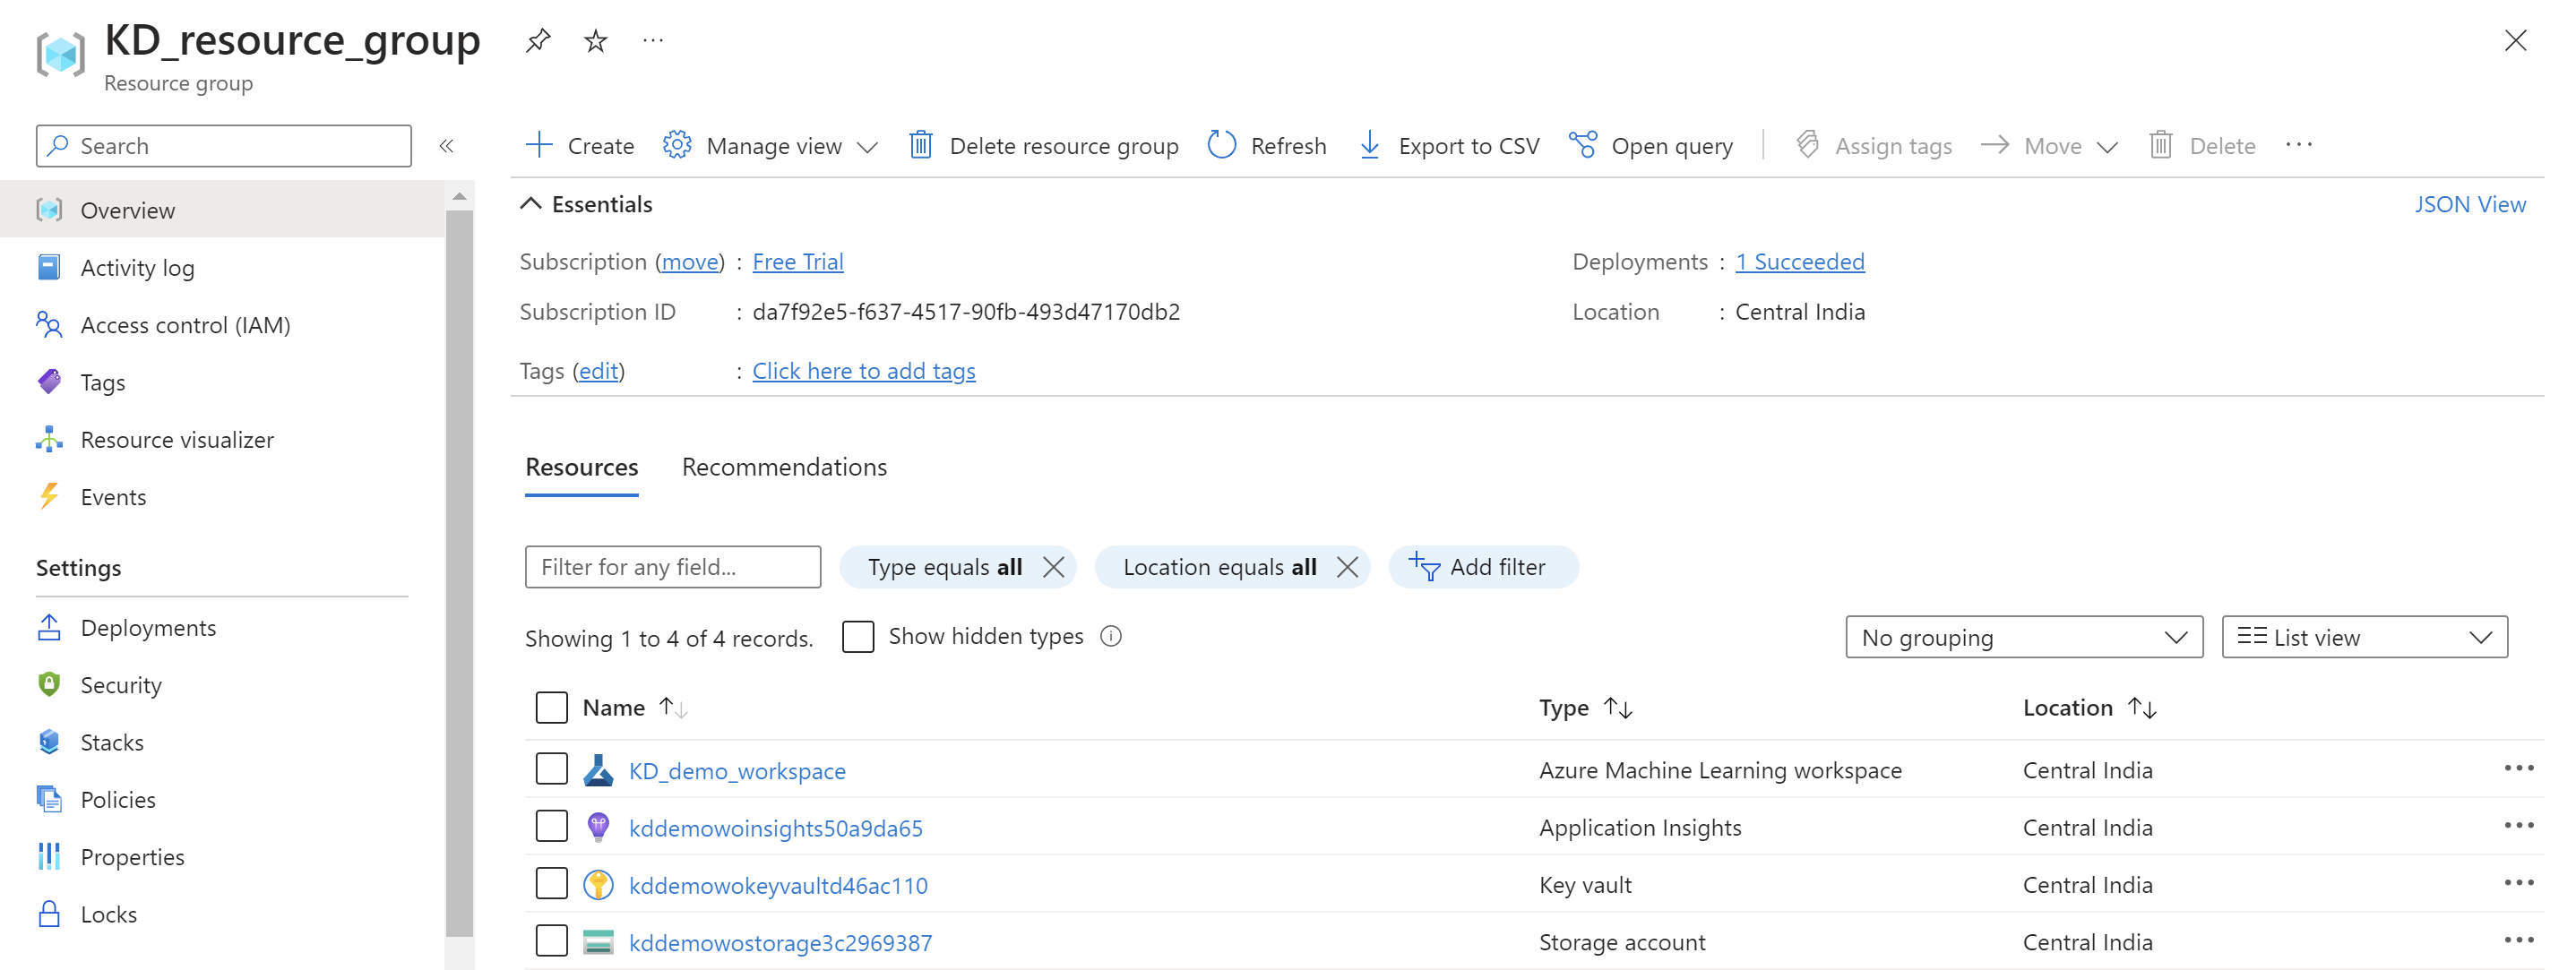

In [5]:
ws=Workspace.from_config()  ## To fetch workspace
ws

Workspace.create(name='KD_demo_workspace', subscription_id='da7f92e5-f637-4517-90fb-493d47170db2', resource_group='KD_resource_group')

In [6]:
print("SDK version:", azureml.core.VERSION)
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

SDK version: 1.49.0
KD_demo_workspace
KD_resource_group
centralindia
da7f92e5-f637-4517-90fb-493d47170db2


**STEP 11:** Now, we need to click on the "Launch Studio" button or the 'Sudio web url' to got to the Azure Ml Studio. <br>
Link for our case : https://ml.azure.com/?tid=d8533050-79a6-4371-8c5b-ddfadb9be8d2&wsid=/subscriptions/b194183f-1d92-4868-8e02-c46f33bc7030/resourcegroups/KD_resource_group/providers/Microsoft.MachineLearningServices/workspaces/demo_azure_ml_workspace <br>
The below screen must come up if all the things are done prooperly as of now.<br><br>
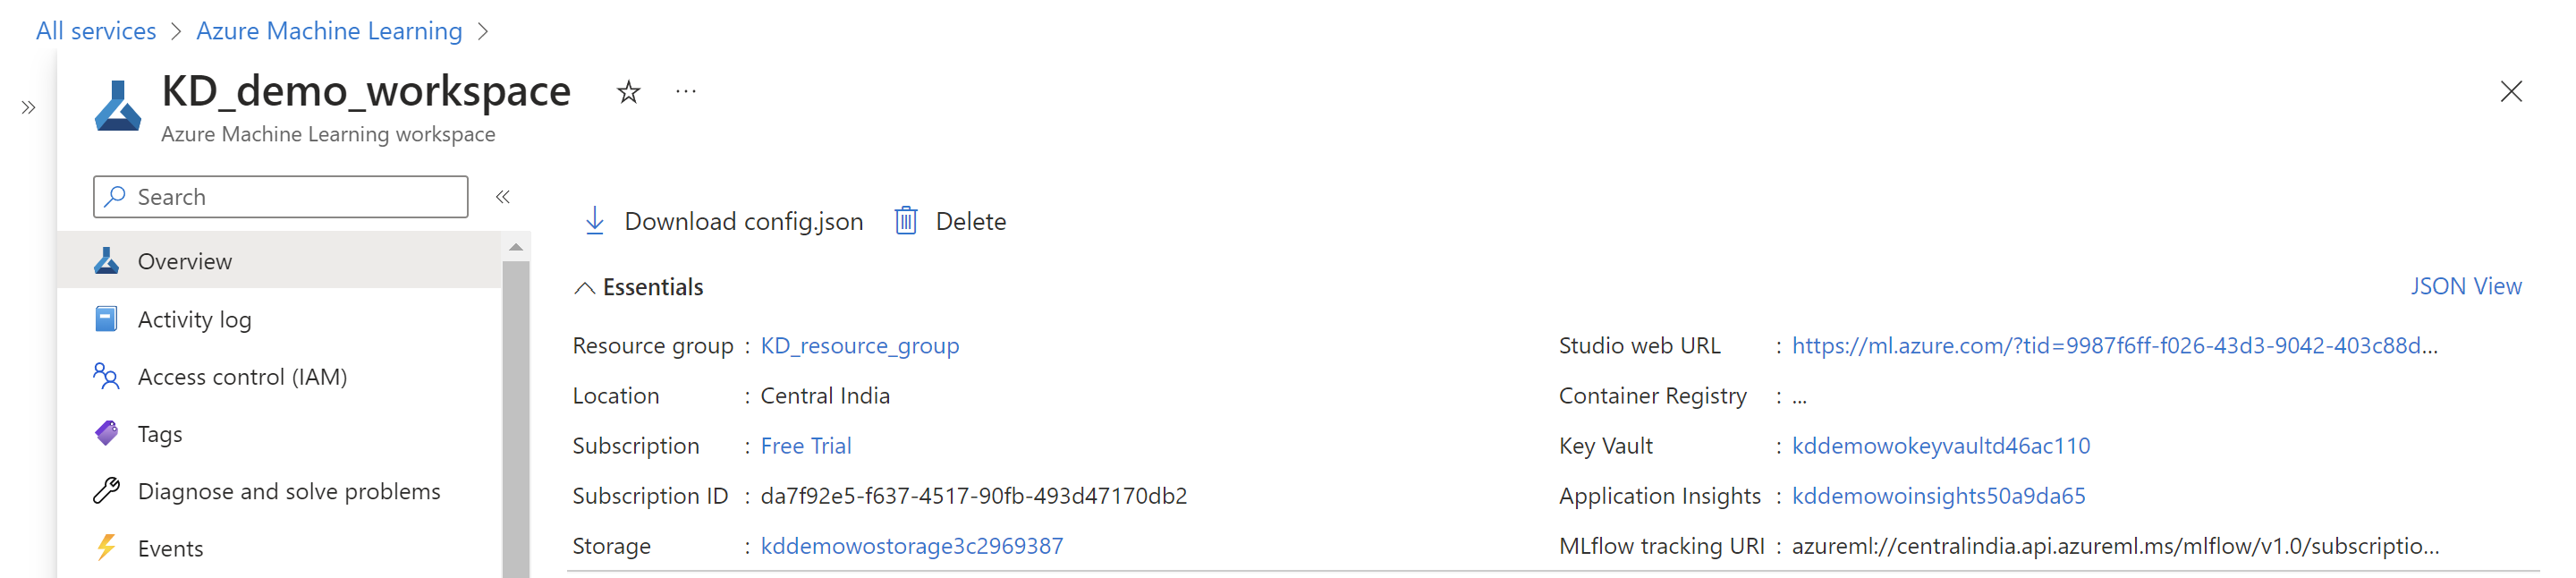

**STEP 12:** Check compute tab at the left of the screen and see if there is any compute instance already created or not. If not then we would have to create a new compute instance to run our ML model.The following code will create a compute instance.

In [8]:
# Create Compute Target if it's not created already
try:
    aml_compute = AmlCompute(ws, aml_compute_target)
    print("This Compute Target already exist.")
except ComputeTargetException:
    print("creating new compute target :",aml_compute_target)
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D2_V2",     # Type of VM to be used 
                                                                min_nodes = 1,                  # Min no of nodes
                                                                max_nodes = 4,                  # Max no of nodes for scale-up
                                               idle_seconds_before_scaledown=3000)             
    aml_compute = ComputeTarget.create(ws, aml_compute_target, provisioning_config)
    aml_compute.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
print("Azure Machine Learning Compute attached now")

creating new compute target : KD-cluster
InProgress.......
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded...............
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
Azure Machine Learning Compute attached now


**STEP 13** After successful execution of the command, we should see the compute instance getting attached in the compute tab. path : azure -> home -> resource_group -> KD_resource_group -> demo_azure_ml_workspace -> Launch studio -> compute -> compute clusters.
<br><br>
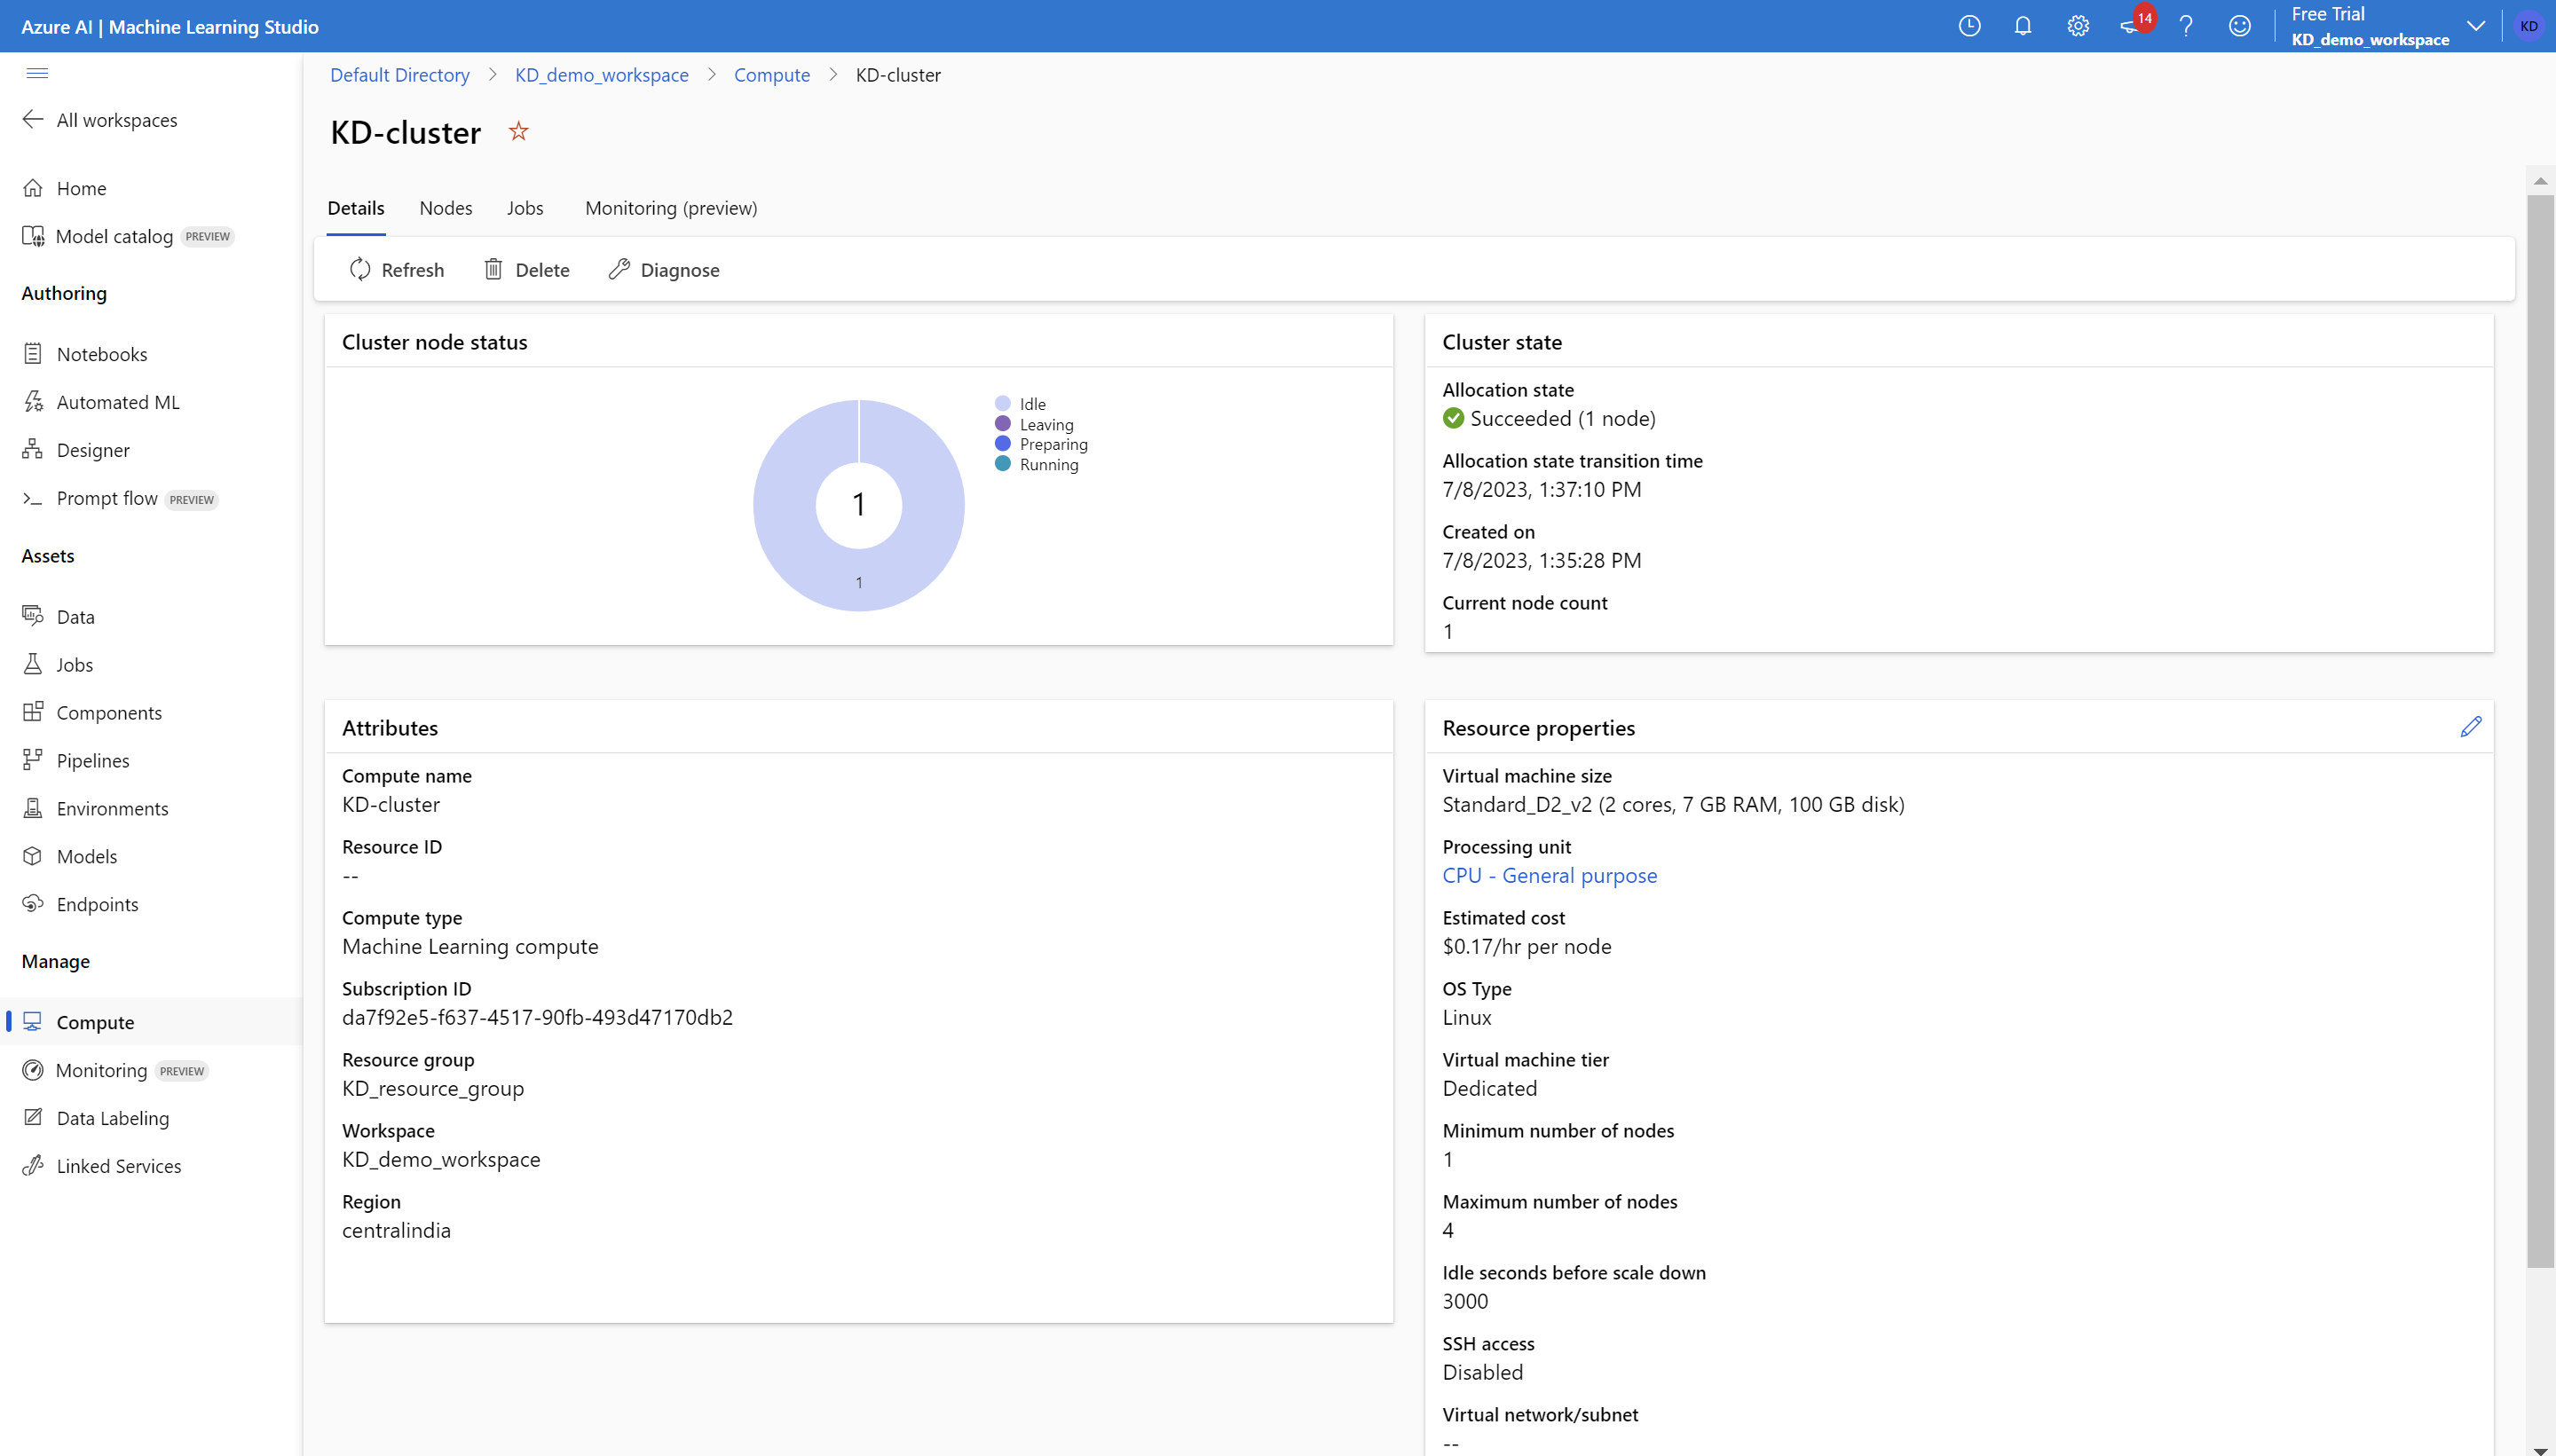

In [7]:
## Checking the compute target that has been craeted
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print(compute.name, ":", compute.type)

KD-cluster : AmlCompute


**STEP 14:** Create Experiment using the following command and check if the experiment has been created successfully or not from the path azure -> home -> resource_group -> KD_resource_group -> demo_azure_ml_workspace -> Launch studio -> jobs<br>

In [13]:
exp=Experiment(workspace=ws, name=experiment_name,)
run = exp.start_logging()                            # Start logging data from the experiment
run.complete()                                       # Complete the experiment

In [11]:
exp

Name,Workspace,Report Page,Docs Page
demo_expirement_1,KD_demo_workspace,Link to Azure Machine Learning studio,Link to Documentation


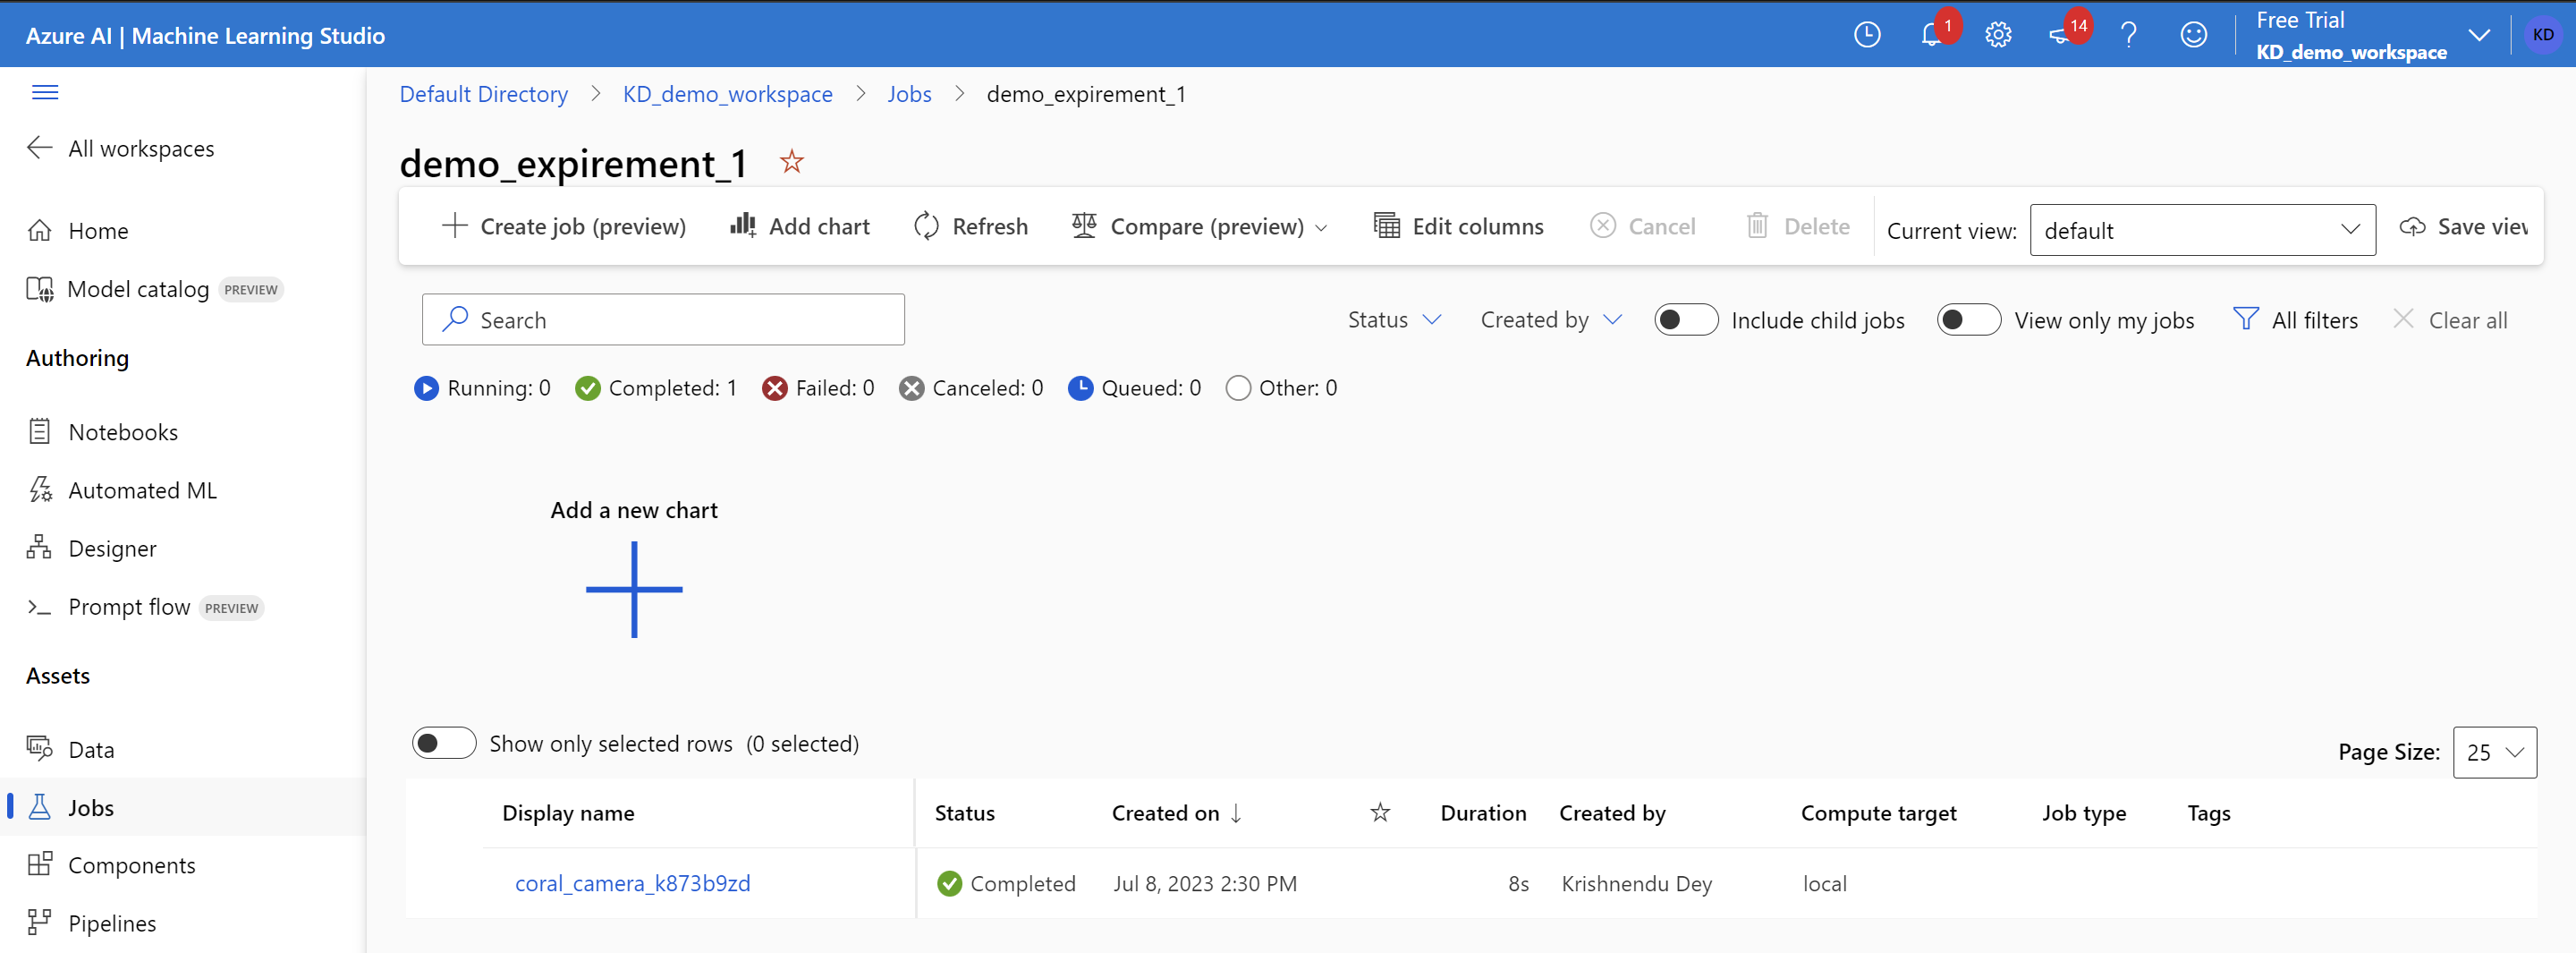

**Logging**

In [39]:
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_diabetes


data =  load_diabetes()
X = pd.DataFrame(data= data['data'], columns=data.feature_names)
Y = pd.Series(data['target'])
row_count = (len(X))

In [40]:
# Log the row count
run.log('observations', row_count)
run.complete()

**Retreiving the logs**

In [41]:
### The logs can be viewed using RunDetails
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [43]:
import json
# Get logged metrics
metrics = run.get_metrics()
print(json.dumps(metrics, indent=2))

{
  "observations": [
    8,
    442
  ]
}


**STEP 15**: Working with datastore:<br>

In [72]:
### Fetching the default datastores 
default_ds=ws.get_default_datastore()
default_ds

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-8f813250-e78c-4309-9f63-32f488470208",
  "account_name": "kddemowostorage3c2969387",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

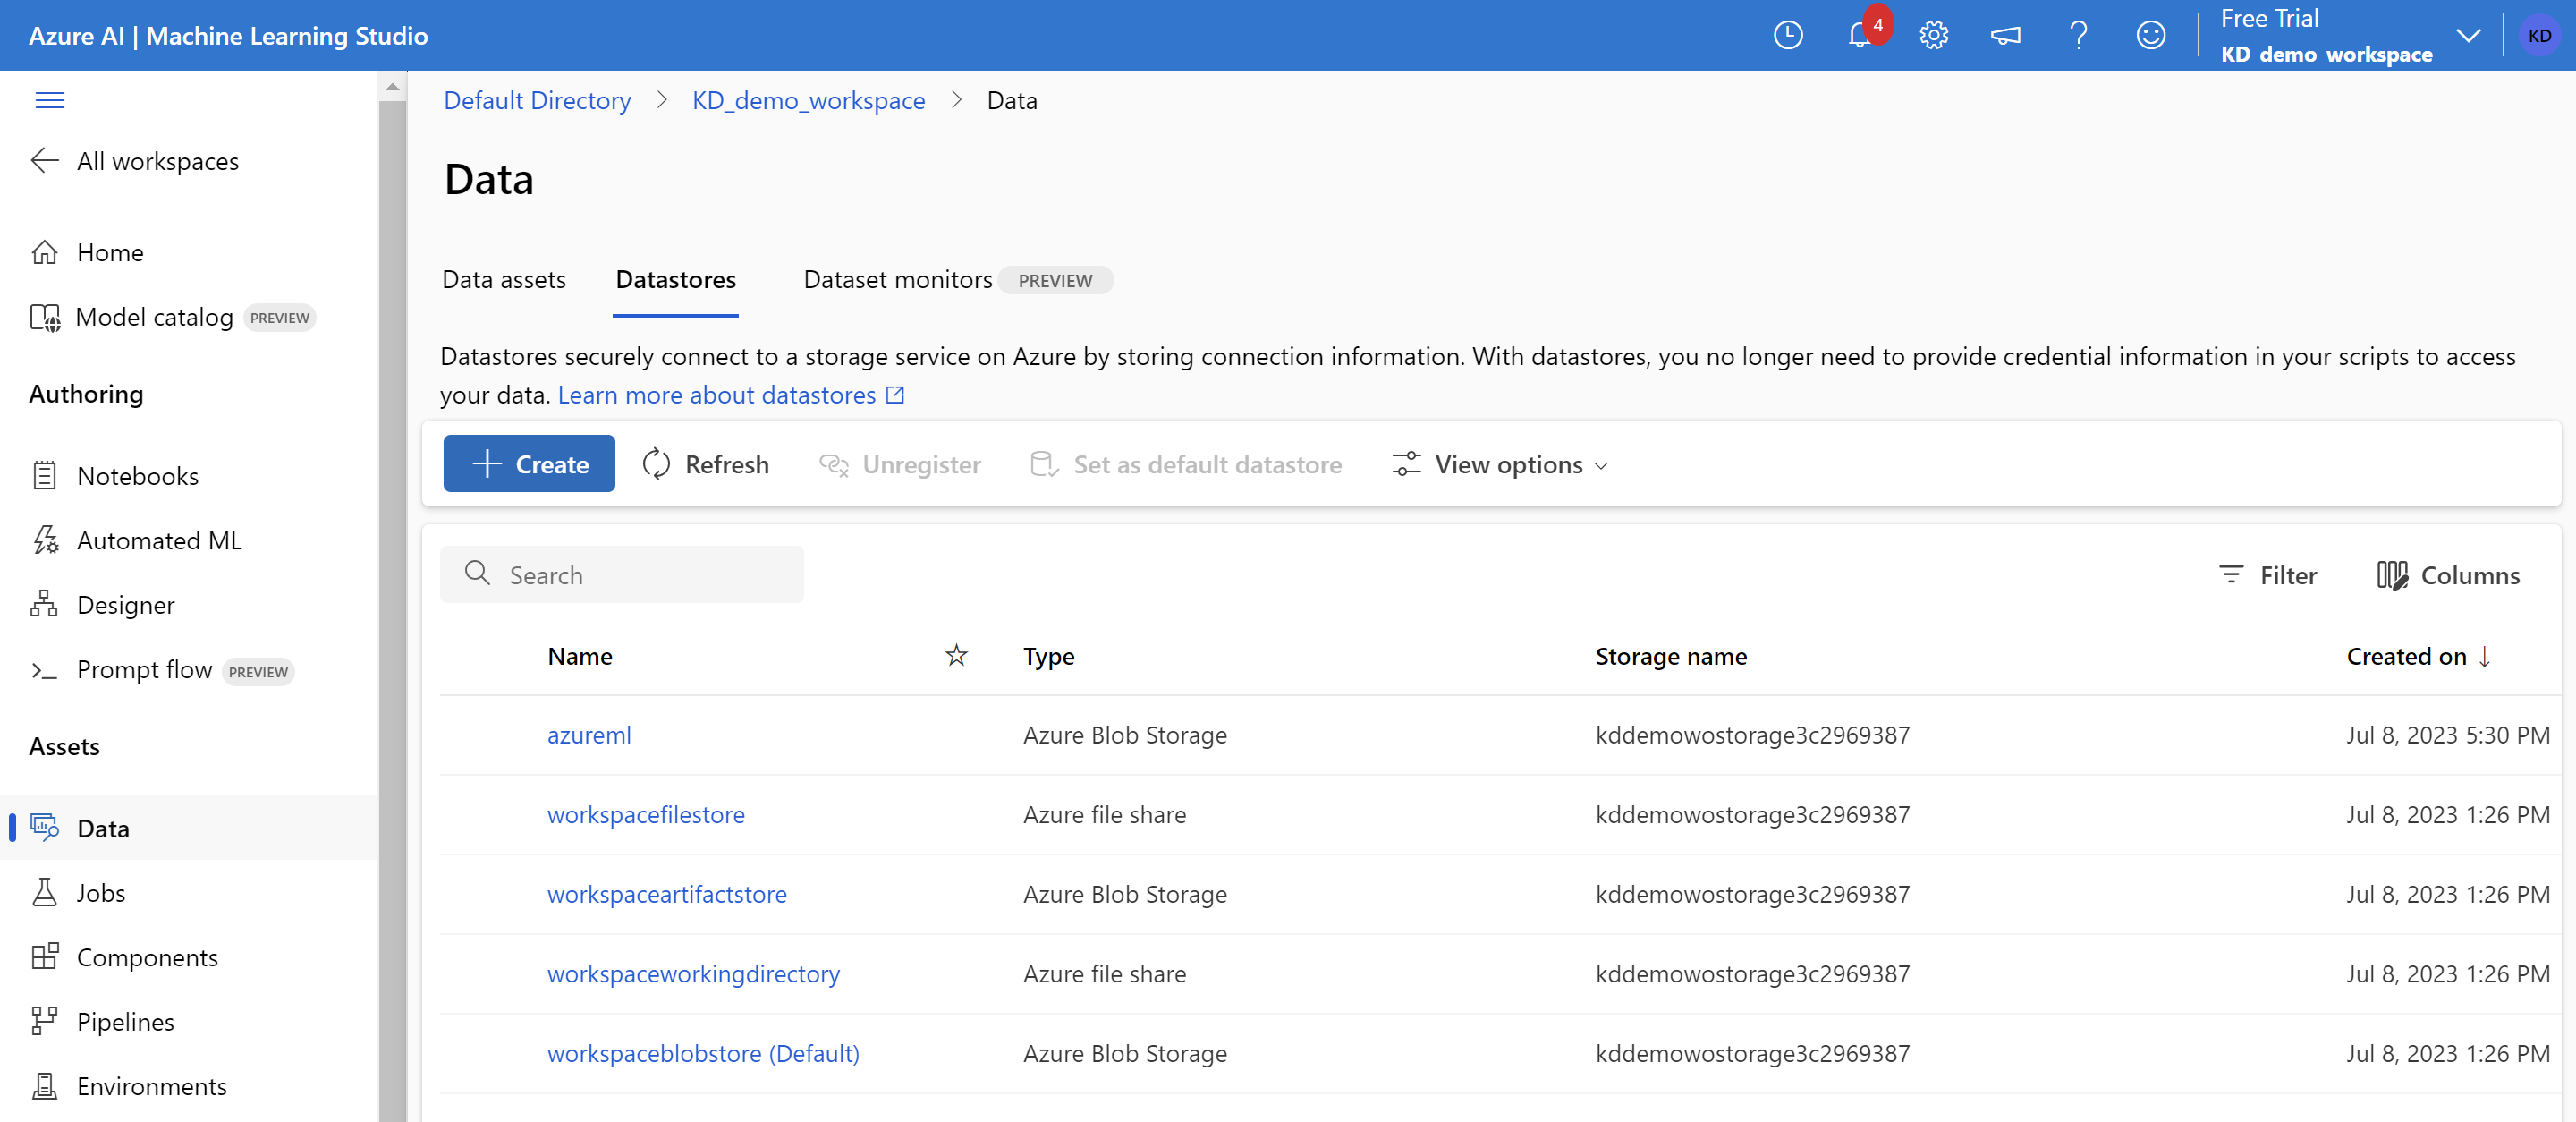

In [73]:
### Uploading a file in the default ds
default_ds.upload_files(files=['diabetes.csv'],
                       target_path='diabetes_data/',
                       overwrite=True,
                       show_progress=True)

"datastore.upload_files" is deprecated after version 1.0.69. Please use "FileDatasetFactory.upload_directory" instead. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 1 files
Uploading diabetes.csv
Uploaded diabetes.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_789addfab01e440b852a7af2a17b187f

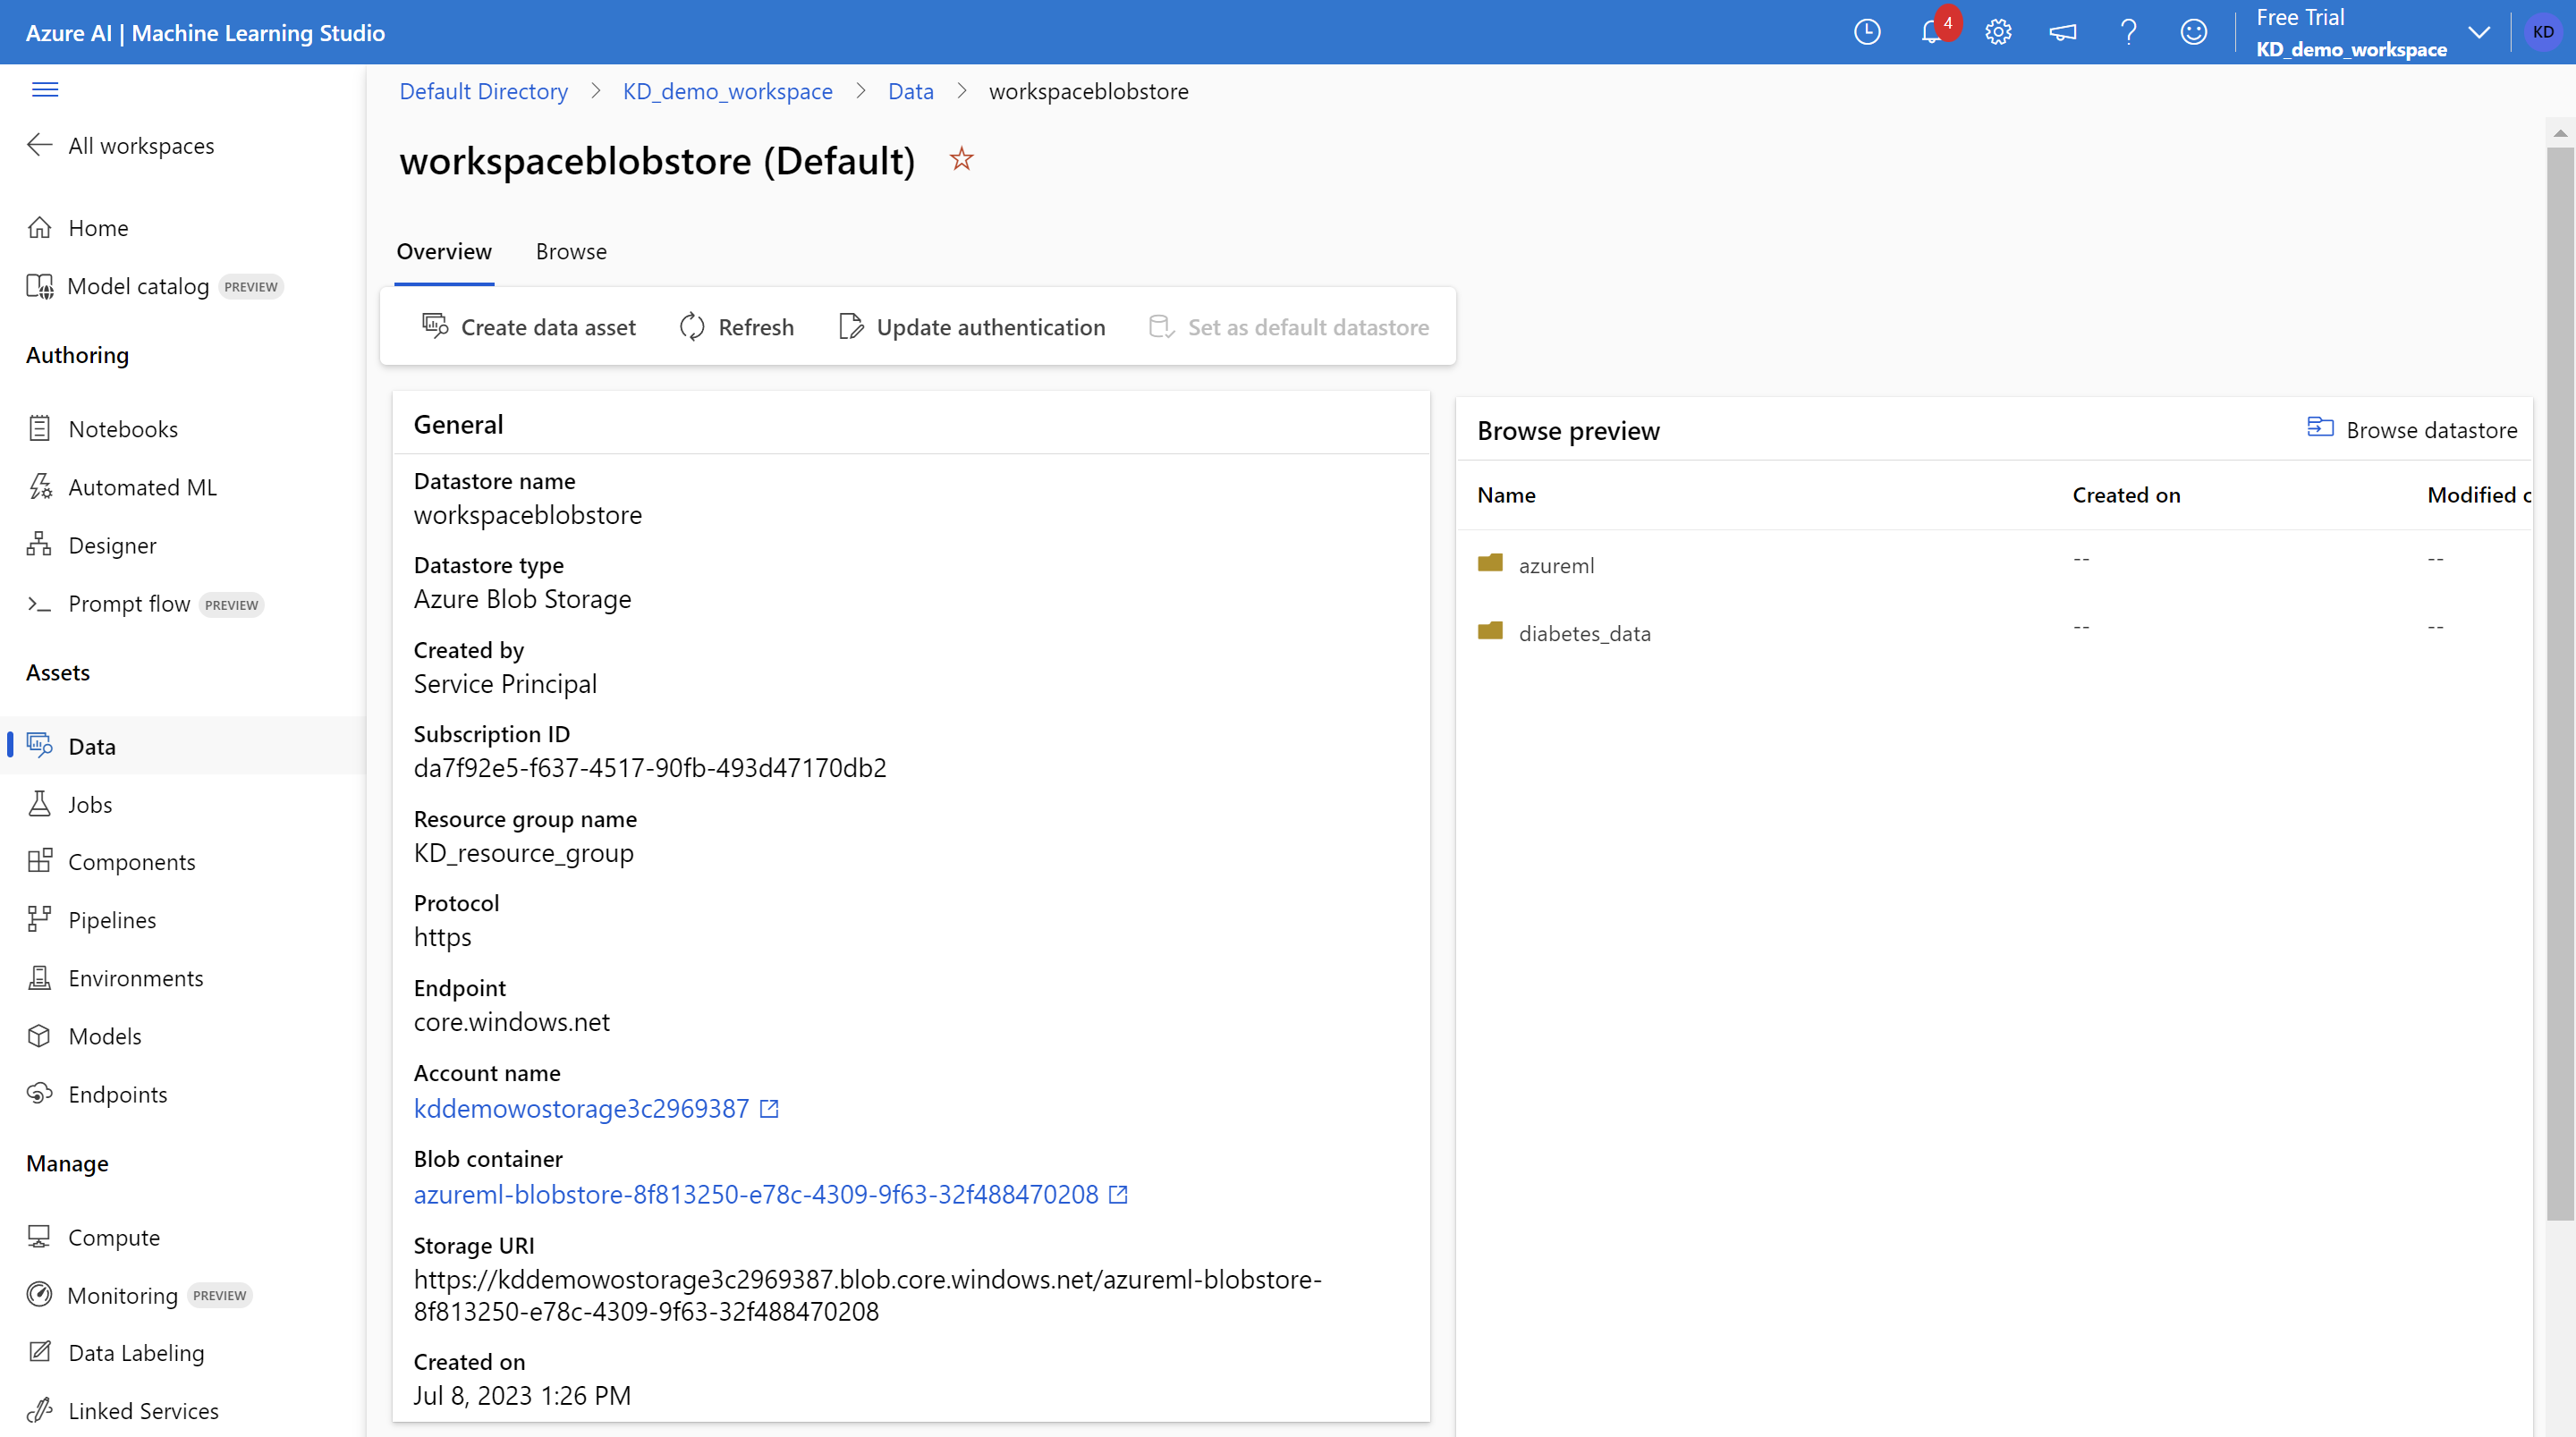

In [74]:
#### Reading data in the form of dataset from datastore 
from azureml.core import Dataset
dataset=Dataset.Tabular.from_delimited_files(path=(default_ds, 'diabetes_data/diabetes.csv'))
df=dataset.to_pandas_dataframe()
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [75]:
### Registering the dataset
try:
    dataset = dataset.register(workspace=ws,
                            name='diabetes dataset',
                            description='diabetes data',
                            create_new_version=True,
                            tags={'format':'csv'})
except Exception as ex :
    print(ex)

In [76]:
### Fetching all the datafiles 
datafiles=Dataset.File.from_files(path=(default_ds, 'diabetes_data/diabetes.csv'))
for filepath in datafiles.to_path():
    print(filepath)

/diabetes.csv


In [77]:
### Registering datafiles 
try:
    datafiles=datafiles.register(workspace=ws,
                            name='diabetes files',
                            description='diabetes files',
                            create_new_version=True,
                            tags={'format':'csv'})
except Exception as ex :
    print(ex)

In [83]:
# print(dataset)
# print(datafiles)

In [82]:
## Fetching the diabetes dataset
diabetes_ds=ws.datasets.get('diabetes dataset') 
# Alternate Query: Dataset.get_by_name(workspace=ws, name='diabetes dataset', version=1)
diabetes_ds

{
  "source": [
    "('workspaceblobstore', 'diabetes_data/diabetes.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "ba38ecfd-9fd7-45b1-830b-888e2b03dd7d",
    "name": "diabetes dataset",
    "version": 1,
    "description": "diabetes data",
    "tags": {
      "format": "csv"
    },
    "workspace": "Workspace.create(name='KD_demo_workspace', subscription_id='da7f92e5-f637-4517-90fb-493d47170db2', resource_group='KD_resource_group')"
  }
}

In [84]:
input_data  = diabetes_ds.as_named_input('dataset')
input_data

**STEP 15**: Creating environment and training model:<br>
In this step we actually specify our required libraries and packages that are to be needed to run the code in the .py file. That environment will be set up in the azure VMs and our code will be executed through the vm in the cloud. To run a script as an experiment, you must define a script configuration that defines the script to be run and the Python environment in which to run it. This is implemented by using a ScriptRunConfig object. This step takes approx 15 mins to execute.

In [8]:
# Creating environment : make sure you are in the same directory where mytrain.py and envfile.yml files are kept
env = Environment.from_conda_specification(name=environment_name,
                                           file_path="./envfile.yml",)
env.register(workspace=ws)                                              # Registering the environemt for future use in the same workspace
env

{
    "assetId": null,
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:20230120.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "buildContext": null,
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": "2g"
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "azure_ml_demo",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
       

Note : Changing hyperparameters and training the model and validating it again by triggering a new job altogether. To use parameters in a script, you must use a library such as ***argparse*** in the mytrain.py file to read the arguments passed to the script and assign them to variables

In [10]:
## ScriptRunConfig is used to run the machine learning model from notebook which runs through VMs in the cloud
config=ScriptRunConfig(source_directory="./",script="mytrain.py",
                       compute_target=aml_compute_target,
                       environment=env,)

execution=exp.submit(config)
execution.wait_for_completion(show_output=True)

RunId: demo_expirement_1_1688811327_cb3ddc60
Web View: https://ml.azure.com/runs/demo_expirement_1_1688811327_cb3ddc60?wsid=/subscriptions/da7f92e5-f637-4517-90fb-493d47170db2/resourcegroups/KD_resource_group/workspaces/KD_demo_workspace&tid=9987f6ff-f026-43d3-9042-403c88da284a

Streaming user_logs/std_log.txt

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
Accuracy on training set: 1.000
Accuracy on test set: 0.766
Accuracy 0.7662337662337663
0.7662337662337663
Cleaning up all outstanding Run operations, waiting 300.0 seconds
1 items cleaning up...
Cleanup took 0.10429525375366211 seconds

Execution Summary
RunId: demo_expirement_1_1688811327_cb3ddc60
Web View: https://ml.azure.com/runs/demo_expirement_1_1688811327_cb3ddc60?wsid=/subscriptions/da7f92e5-f637-4517-90fb-493d47170db2/resourcegroups/KD_resource_group/workspaces/KD_demo_workspace&tid=9987f6ff-f026-43d3-9042-403c

{'runId': 'demo_expirement_1_1688811327_cb3ddc60',
 'target': 'KD-cluster',
 'status': 'Completed',
 'startTimeUtc': '2023-07-08T10:15:43.09724Z',
 'endTimeUtc': '2023-07-08T10:15:57.475597Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlctrain',
  'ContentSnapshotId': '1aac51a8-6f10-4878-9283-68729dbb58ba',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'mytrain.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--min_samples_leaf', '5', '--min_samples_split', '7'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'KD-cluster',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'datacaches': [],
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'instanceTypes': [],
  'priority': None,
  'credentialPassthrough': False,
  'iden

When the code gets successfully executed, then go to jobs and check if the job id has completed or not from azure. <br>
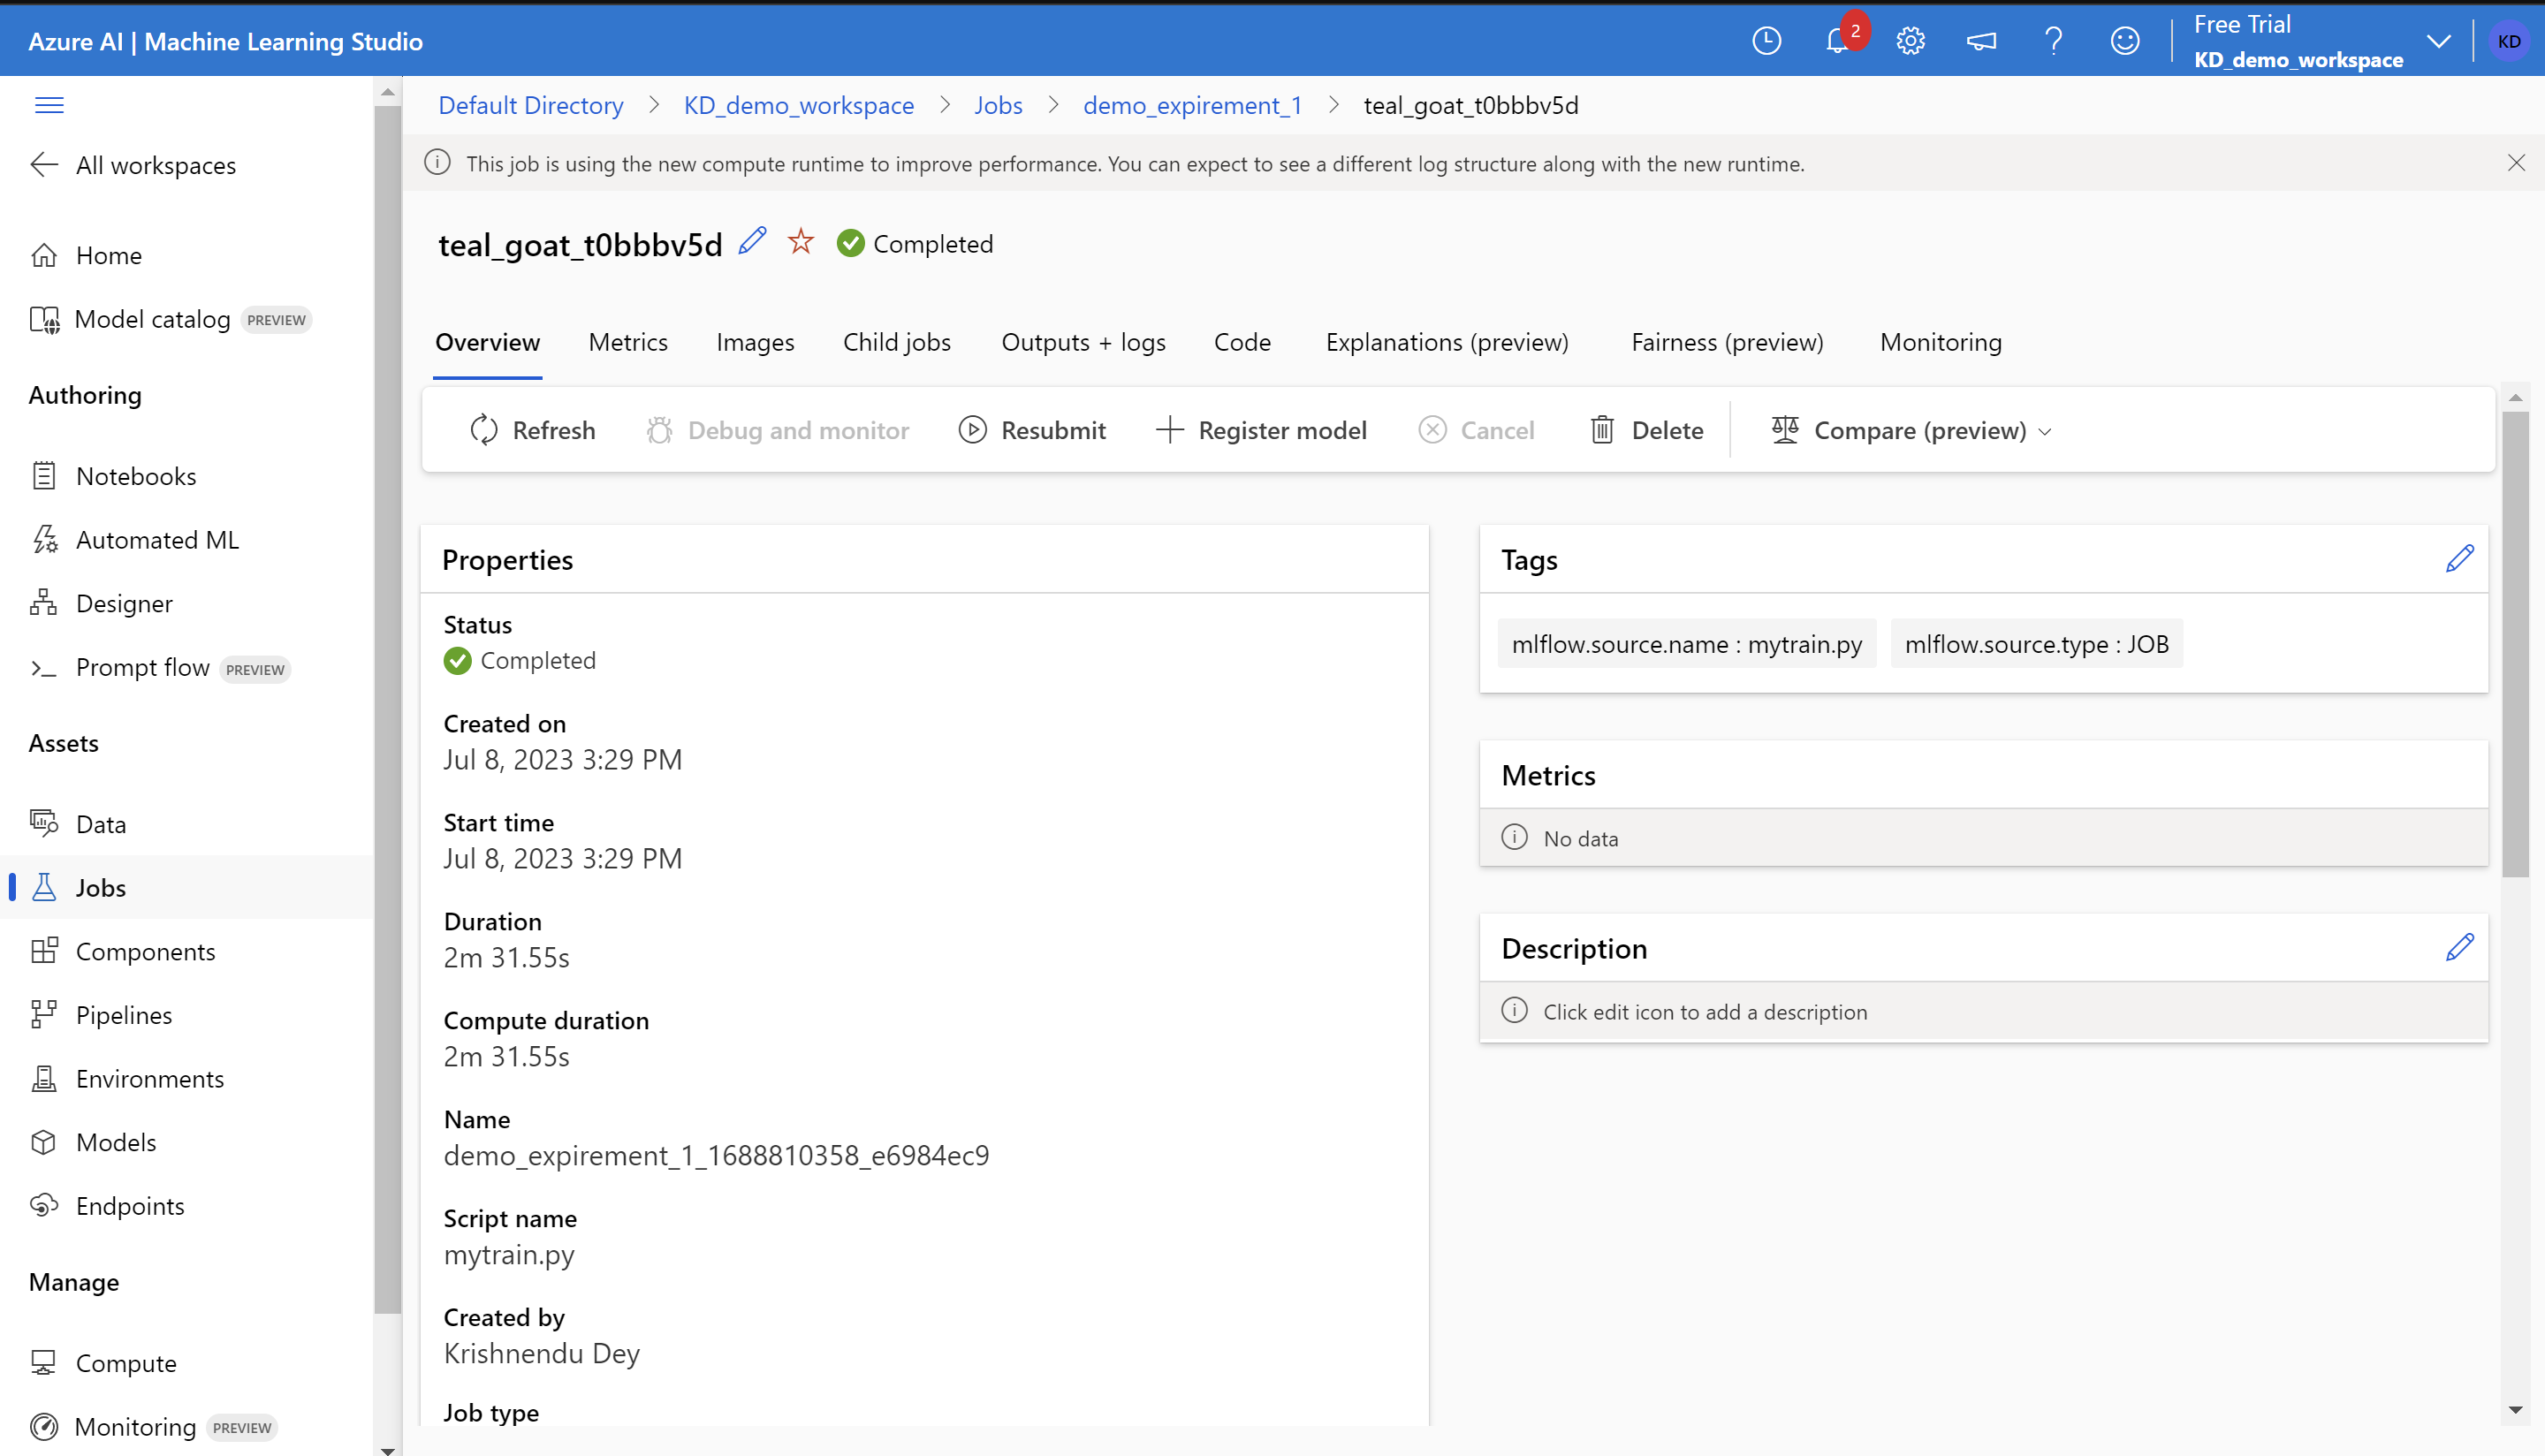

**STEP 16:** To check how the model performs, go to outputs and logs tab. <br><br>
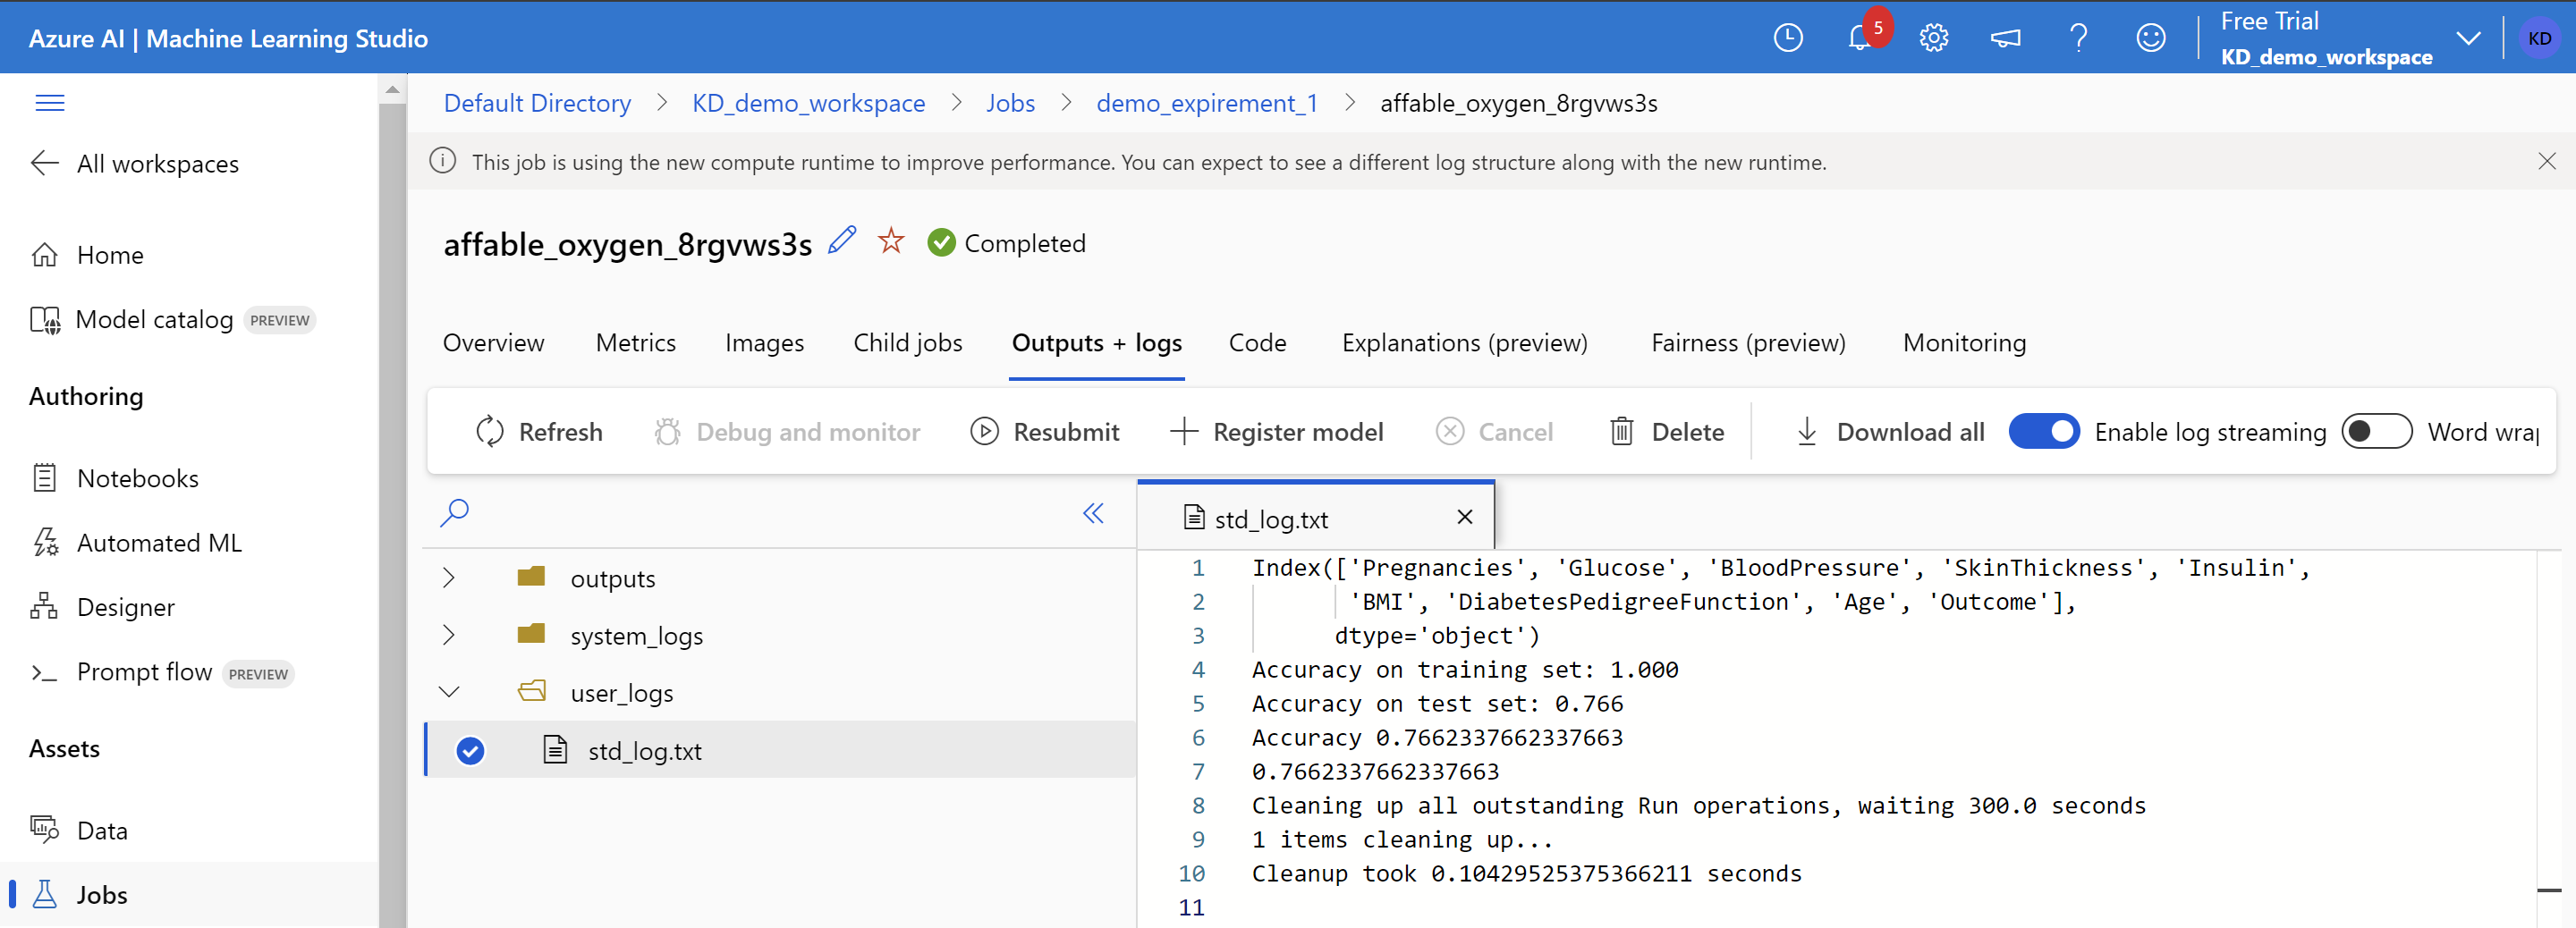

In [15]:
execution

Experiment,Id,Type,Status,Details Page,Docs Page
demo_expirement_1,demo_expirement_1_1688811327_cb3ddc60,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


**STEP 17:** Now the above steps would not give us anything getting displayed on the Metrics tab for the job. To populate the results of the population matrics on the tab we need to make certain modification to the code.The code with specific changes can be found in the mytrain_log.py file.

In [89]:
config=ScriptRunConfig(source_directory="./",
                        script="train.py",
                        compute_target=aml_compute_target,
                        environment=env,
                        arguments=['--min_samples_leaf',5,
                                   '--min_samples_split',7,
                                   '--input_data',input_data,])
execution=exp.submit(config)

In [90]:
execution

Experiment,Id,Type,Status,Details Page,Docs Page
demo_expirement_1,demo_expirement_1_1688823934_62bccc2e,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


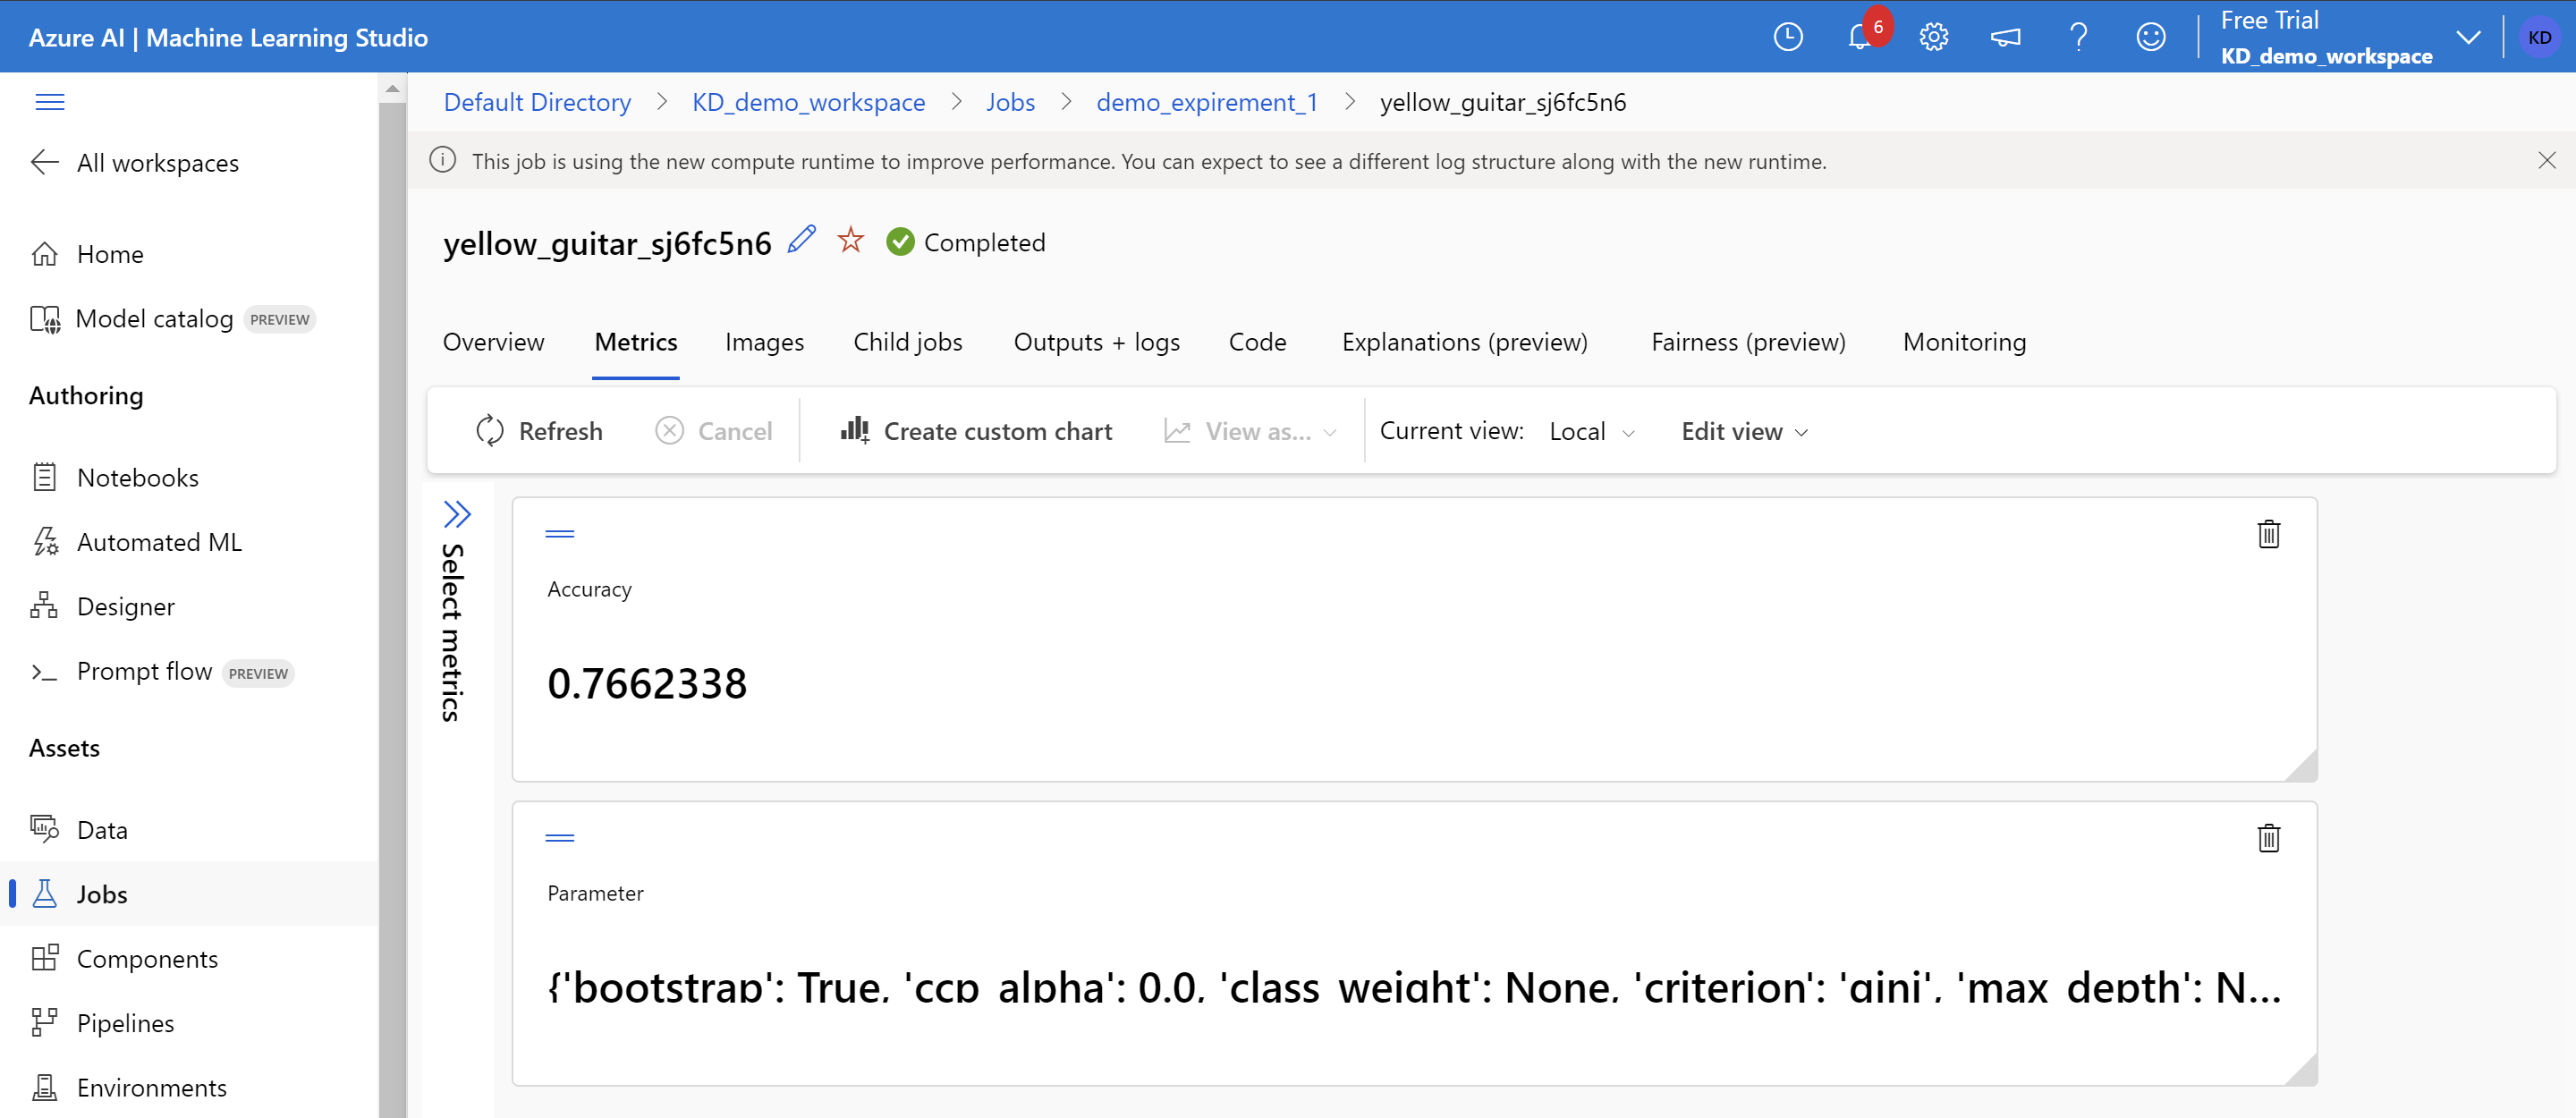

**STEP 19:** So far the model has been built in the backend and the training and testing is done using azure VM. But if we want to see the model from the UI , we won't be able to coz the model would not be there in the models option of the Azure ML Studio untill we register it for further usage. Below code demonstrates how the model registration is done.

In [69]:
#Register model in workspace
model_name = "diabetic_model_1"
model = Model.register(ws,
                       model_path="./outputs/diabeticmodel.pkl",
                       model_name= model_name,
                       model_framework=Model.Framework.SCIKITLEARN,
                       description='A classification model',
                       tags={'data-format': 'CSV'},)

Registering model diabetic_model_1


In [70]:
model

Model(workspace=Workspace.create(name='KD_demo_workspace', subscription_id='da7f92e5-f637-4517-90fb-493d47170db2', resource_group='KD_resource_group'), name=diabetic_model_1, id=diabetic_model_1:2, version=2, tags={'data-format': 'CSV'}, properties={})

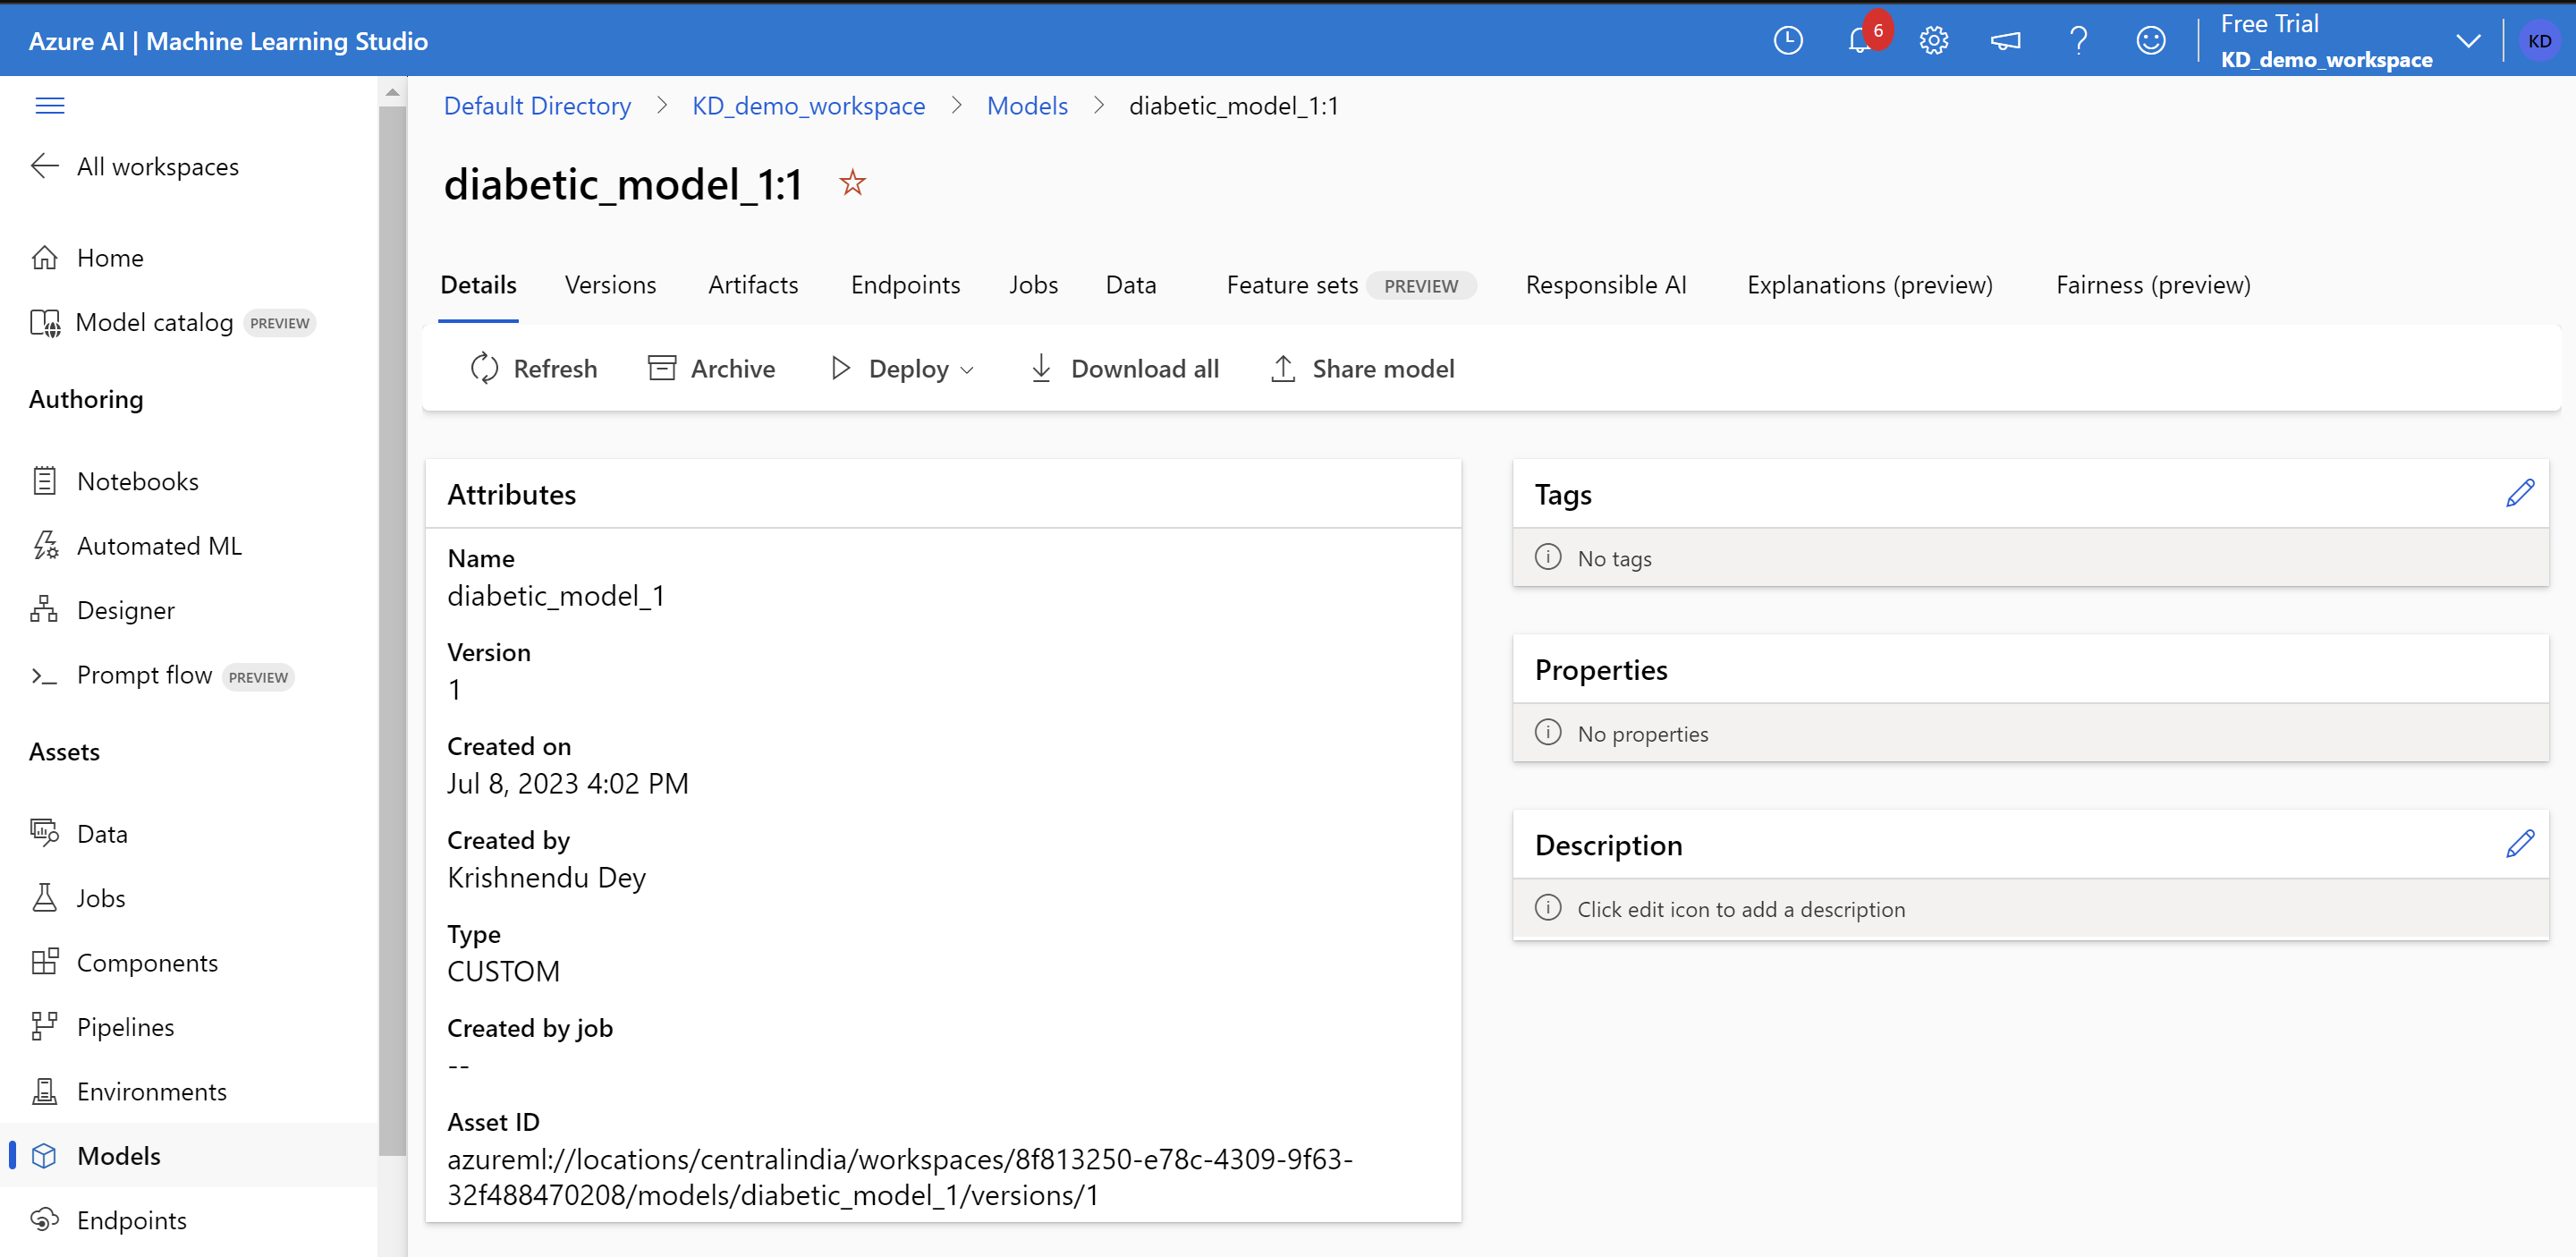

In [71]:
## Retrieving registered model
for model in Model.list(ws):
    print("Model Name : ", model.name,"|", "version :", model.version)

Model Name :  diabetic_model_1 | version : 2
Model Name :  diabetic_model_1 | version : 1


In [ ]:
### An Alternate way of deploying model
# run.register_model( model_name='classification_model',
#                     model_path='outputs/diabeticmodel.pkl',             # run outputs path of the model in the cloud
#                     description='A classification model',
#                     tags={'data-format': 'CSV'},
#                     model_framework=Model.Framework.SCIKITLEARN,
#                     model_framework_version='0.20.3')

**STEP 20- Deploy Registered Model:** <br> 

***STEP 20.1: Getting the Registered ML Model***

In [26]:
## Getting the Registered ML Model
model = Model(ws,model_name)            ## this is how a perticular model is fetched from Model class
model

Model(workspace=Workspace.create(name='KD_demo_workspace', subscription_id='da7f92e5-f637-4517-90fb-493d47170db2', resource_group='KD_resource_group'), name=diabetic_model_1, id=diabetic_model_1:1, version=1, tags={}, properties={})

***STEP 20.2 : Define an inference configuration***

The model will be deployed as a service that consist of:<br>
- A script to load the model and return predictions for submitted data.
- An environment in which the script will be run.

***STEP 20.2.1 : Create an entry script***<br>
Create the entry script (sometimes referred to as the scoring script) for the service as a Python (.py) file. It must include two functions:
- init(): Called when the service is initialized.
- run(raw_data): Called when new data is submitted to the service.
Typically, you use the init function to load the model from the model registry, and use the run function to generate predictions from the input data. The following example script of score.py file shows this pattern:<br>

                    import json
                    import joblib
                    import numpy as np
                    import os
                    def init():
                        global model
                        # Get the path to the registered model file and load it
                        model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'model.pkl')
                        model = joblib.load(model_path)

                    def run(raw_data):
                        # Get the input data as a numpy array
                        data = np.array(json.loads(raw_data)['data'])
                        # Get a prediction from the model
                        predictions = model.predict(data)
                        # Return the predictions as any JSON serializable format
                        return predictions.tolist()

***STEP 20.2.2: Create an environment***<br>
Your service requires a Python environment in which to run the entry script, which you can define by creating an Environment that contains the required packages. This environment is required for inferencing the reesult of the ml model:

In [57]:
## Creating Inference Environment for the model prediction
from azureml.core.model import InferenceConfig
from azureml.core.conda_dependencies import CondaDependencies

myenv=Environment(name="demo-env")                                                       # Creating inference environment
conda_packages = ['numpy']
pip_packages = ['azureml-sdk','azureml-defaults','scikit-learn','pandas', 'numpy','os']       # whatever packages your entry script uses
mycondaenv = CondaDependencies.create(conda_packages=conda_packages, 
                                      pip_packages=pip_packages, 
                                      python_version='3.10.9')
myenv.python.conda_dependencies=mycondaenv
myenv.register(workspace=ws)

{
    "assetId": "azureml://locations/centralindia/workspaces/8f813250-e78c-4309-9f63-32f488470208/environments/demo-env/versions/4",
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:20230120.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "buildContext": null,
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "demo-env",
    "python"

In [58]:
# Combine the script and environment in an InferenceConfig
inference_config = InferenceConfig(entry_script='score.py',
                                   source_directory='.',
                                   environment=myenv)
inference_config

InferenceConfig(entry_script=score.py, runtime=None, conda_file=None, extra_docker_file_steps=None, source_directory=C:\Users\krish\OneDrive\Desktop\Study\Azure MLOPs\DP 100 Certifications, enable_gpu=None, base_image=None, base_image_registry=<azureml.core.container_registry.ContainerRegistry object at 0x0000027887695660>)

***STEP 20.3 : Define a deployment configuration***<br>
Now that you have the entry script and environment, you need to configure the compute to which the service will be deployed. If you are deploying to an AKS cluster, you must create the cluster and a compute target for it before deploying:

In [59]:
### Specifying the machines of what configuration would be required to make predictions
from azureml.core.webservice import AciWebservice
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1,memory_gb=2)
aciconfig

***STEP 20.4: Deployment***<br>

In [91]:
%%time
## Deploying model as a service for real time predictions
service = Model.deploy(ws,"model-endpoint",                          #This is endpoint name
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aciconfig,
                           #deployment_target=predenv,
                           overwrite=True)
service.wait_for_deployment(show_output=True)
url = service.scoring_uri
print(url)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2023-07-08 19:18:25+05:30 Creating Container Registry if not exists.
2023-07-08 19:18:25+05:30 Registering the environment.
2023-07-08 19:18:25+05:30 Building image.
Failed


Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: 2c6d382b-6cf4-4289-9ed2-aeb40cb36fd6
More information can be found here: 
Error:
{
  "code": "EnvironmentBuildFailed",
  "statusCode": 400,
  "message": "Failed building the Environment. You can try debugging locally first. Please refer to https://aka.ms/debugimage#debug-locally for more information."
}



WebserviceException: WebserviceException:
	Message: Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: 2c6d382b-6cf4-4289-9ed2-aeb40cb36fd6
More information can be found here: 
Error:
{
  "code": "EnvironmentBuildFailed",
  "statusCode": 400,
  "message": "Failed building the Environment. You can try debugging locally first. Please refer to https://aka.ms/debugimage#debug-locally for more information."
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Service deployment polling reached non-successful terminal state, current service state: Unhealthy\nOperation ID: 2c6d382b-6cf4-4289-9ed2-aeb40cb36fd6\nMore information can be found here: \nError:\n{\n  \"code\": \"EnvironmentBuildFailed\",\n  \"statusCode\": 400,\n  \"message\": \"Failed building the Environment. You can try debugging locally first. Please refer to https://aka.ms/debugimage#debug-locally for more information.\"\n}"
    }
}

In [61]:
print(service.get_logs())

Error in environment creation, more details may be found here: https://kddemowostorage3c2969387.blob.core.windows.net/azureml/ImageLogs/e0e91736-ed72-4e35-b7a0-b3da81099b90/build.log 


In [55]:
## Fetching the deployed service and examining it's health 
model_endpoint_name = "model-endpoint"
service = AciWebservice(name = model_endpoint_name, workspace=ws)
print(service.state)

Unhealthy


After Deployment is done, go to endpoint to see the serivce that has been deployed.<br>
![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [ ]:
## to get the logs if the service health is not "Healthy"
# print(service.get_logs())

**STEP 21: Testing the Deployed Model**<br>

In [63]:
# Prepare your test data
import pandas as pd
import json
data = pd.read_csv('test.csv')
xt = data.values.tolist()
test = json.dumps({"data":xt})

In [64]:
test[:59]

'{"data": [[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0],'

In [ ]:
# Fetching the deployed model 
from azureml.core import Webservice
service = Webservice(workspace=ws, name="demo-model")
print(service.scoring_uri)
print(service.swagger_uri)

http://905ed832-9412-4764-886c-7b84317f6e2a.centralindia.azurecontainer.io/score
http://905ed832-9412-4764-886c-7b84317f6e2a.centralindia.azurecontainer.io/swagger.json


In [ ]:
# Running the predictions 
prediction = service.run(input_data=test)
prediction[:10]

[1, 0, 0, 0, 1, 0, 1, 0, 1, 1]

In [ ]:
## Real-Time predictions using REST call
import requests
headers = {'content-Type':'application/json'}

response = requests.post(service.scoring_uri, test, headers=headers)
response.text

'[1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,

**NOTE: Local Deployment in Docker**<br>

In [68]:
## It will work when Docker is installed in the PC
from azureml.core.webservice import LocalWebservice
deployment_config = LocalWebservice.deploy_configuration(port=5002)
local_service = Model.deploy(ws, 
                       'test-deployment-1', 
                       [model], 
                       inference_config=inference_config,
                       deployment_config=deployment_config)

Failed to create Docker client. Is Docker running/installed?
When you deploy locally, we download a dockerfile
execute docker build on it, and docker run the built container for you
Error: Error while fetching server API version: (2, 'CreateFile', 'The system cannot find the file specified.')



WebserviceException: WebserviceException:
	Message: Failed to create Docker client. Is Docker running/installed?
When you deploy locally, we download a dockerfile
execute docker build on it, and docker run the built container for you
Error: Error while fetching server API version: (2, 'CreateFile', 'The system cannot find the file specified.')
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Failed to create Docker client. Is Docker running/installed?\nWhen you deploy locally, we download a dockerfile\nexecute docker build on it, and docker run the built container for you\nError: Error while fetching server API version: (2, 'CreateFile', 'The system cannot find the file specified.')"
    }
}

**STEP 22:Authentication**<br>
In production, you will likely want to restrict access to your services by applying authentication. There are two kinds of authentication you can use:<br>

- ***Key:*** Requests are authenticated by specifying the key associated with the service.
- ***Token:*** Requests are authenticated by providing a JSON Web Token (JWT).

By default, authentication is disabled for ACI services, and set to key-based authentication for AKS services (for which primary and secondary keys are automatically generated). You can optionally configure an AKS service to use token-based authentication (which is not supported for ACI services).

Assuming you have an authenticated session established with the workspace, you can retrieve the keys for a service by using the get_keys method of the WebService object associated with the service:

In [ ]:
# primary_key, secondary_key = service.get_keys()
# print(primary_key)

In [ ]:
# Set additional parameter key_or_token to make predictions from the deployed model
import requests
headers = { "Content-Type":"application/json",
            "Authorization":"Bearer " + key_or_token }

response = requests.post(service.scoring_uri, test, headers=headers)
response.text
